
## ======================================================================
## CIVE 7336 – Finite Element Methods
## Final Project
## Instructor: Professor K. B. Nakshatrala
## Author: Taiwo Adebiyi
## Last Modified: 2025-12-15
##### ======================================================================


In [1]:

import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

repo_root = Path('.').resolve()
parent_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))
if str(parent_root) not in sys.path:
    sys.path.append(str(parent_root))

from Physics_model.Kernel_LE.taiwo_linear_elasticity import (
    CalculateGlobalMatrices,
    Create_ConstraintsVector,
    PostProcessing,
    Get_Elastic_Moduli,
    Driver_LE,
)

from FemFrameWork.taiwo_gauss_points import GaussPoints
from FemFrameWork.taiwo_shape_functions import ShapeFunctions, Create_ID_Matrix

from Error_Analysis.taiwo_error_analysis_LE import Calculate_Error
from Physics_model.Kernel_LE.taiwo_stress_recovery import Stress_Recovery



-------------------------------------------------------------------------------------------------------------------------
## Section I: Code Development 
-------------------------------------------------------------------------------------------------------------------------

#### The Driver_LE and CalculateLocalMatrices have been implemented in the Kernel_LE directory which we now make use to solve all problems given in the project.


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## Section II: Convergence Analysis Using Canonical Problems
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 1. Deformation of a Rod under Self-Weight

The boundary value problem, derived analytical solutions, and parameters definition are provided in the project report.


#### 1.3 Using FEM approach

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Saved figure to DataFiles_LE\img\rod_self_weight_verification.png


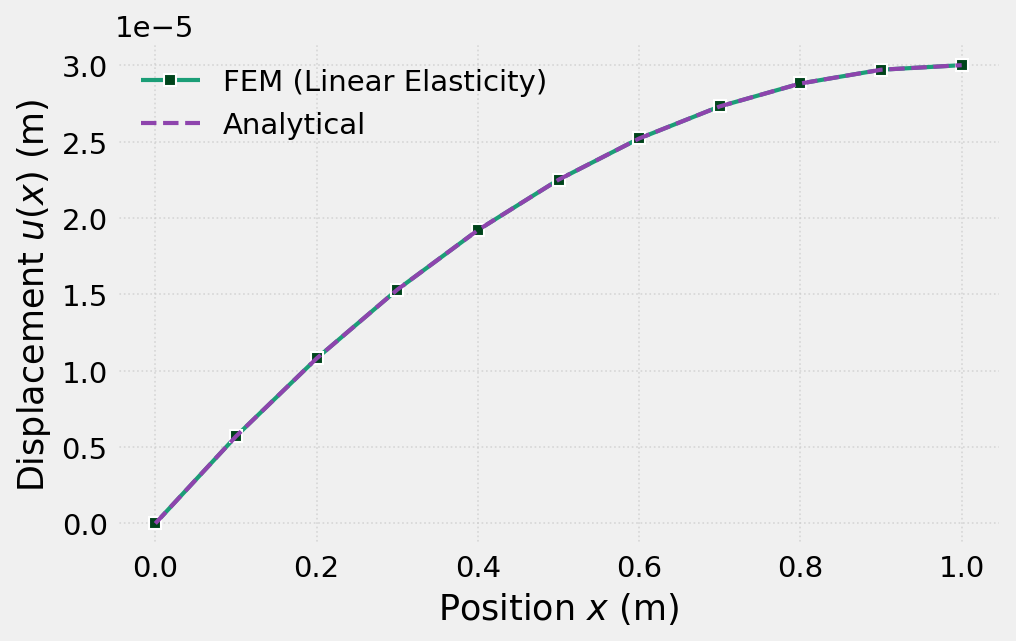

In [2]:

# -------------------------------------------------------------------
# Directory for images (same pattern you used before)
# -------------------------------------------------------------------
IMG_DIR = Path("DataFiles_LE/img")
IMG_DIR.mkdir(parents=True, exist_ok=True)


# -------------------------------------------------------------------
# Simple 1D bar mesh (same as diffusion example)
# -------------------------------------------------------------------
def build_bar_mesh(num_elements, length=1.0):
    num_nodes = num_elements + 1
    coord = np.linspace(0.0, length, num_nodes).reshape(-1, 1)
    # 1-based connectivity: [1,2], [2,3], ...
    connectivity = np.array([[i + 1, i + 2] for i in range(num_elements)], dtype=int)
    return coord, connectivity


# -------------------------------------------------------------------
# Problem data (from your assignment)
# -------------------------------------------------------------------
g = 10.0                 # m/s^2
rho = 1500.0             # kg/m^3
A = 0.5                  # m^2 (not needed for u(x), but useful later for N(x))
L = 1.0                  # m
E = 250e6                # 250 MPa in Pa
nu = 0.0                 # we ignore Poisson's ratio in 1D

# -------------------------------------------------------------------
# Build mesh and constraints
# -------------------------------------------------------------------
num_elements = 10
coord, connectivity = build_bar_mesh(num_elements=num_elements, length=L)

# Essential BC: top end fixed, u(0) = 0
# (node 1, dof 1, value 0.0) — exactly same style as diffusion code
constraints = np.array([[1, 1, 0.0]], dtype=float)

# -------------------------------------------------------------------
# Material (Lamé parameters with nu = 0)
# lambda + 2 mu = E => lambda = 0, mu = E/2
# -------------------------------------------------------------------
medium_set = {
    "type": "Lame_params",
    "lambda": 0.0,
    "mu": 0.5 * E,
}

# -------------------------------------------------------------------
# Body force: 1D gravity
# We use the reduced 1D PDE: E u''(x) + rho g = 0
# so rhob = rho * g (no cross-sectional area in the 1D formulation).
# -------------------------------------------------------------------
load_type = {
    "case": "1D_gravity",
    "rhob": rho * g,
}

# -------------------------------------------------------------------
# Call your linear elasticity driver
# -------------------------------------------------------------------
u_numerical = Driver_LE(
    connectivity,
    constraints,
    coord,
    medium_set,
    dim=1,                # 1D rod
    dofs_per_node=1,      # one axial DOF per node
    EleType="L2",         # 2-node line element
    load_type=load_type,
    NCons=constraints.shape[0],
    Nele=connectivity.shape[0],
    NGPTS=2,              # 2-point Gauss rule is enough for linear elements
)

# -------------------------------------------------------------------
# Analytical solution (symbolic form with problem parameters)
#   u(x) = (rho * g / E) * (L * x - 0.5 * x^2)
# x measured downward from the fixed support at x = 0.
# -------------------------------------------------------------------
x_vals = coord.flatten()
u_exact = (rho * g / E) * (L * x_vals - 0.5 * x_vals**2)

# -------------------------------------------------------------------
# Plot FEM vs Analytical (same style as your diffusion plot)
# -------------------------------------------------------------------
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150)

ax.plot(
    x_vals,
    u_numerical.flatten(),
    label="FEM (Linear Elasticity)",
    marker="s",
    markersize=6,
    markerfacecolor="#00441B",
    markeredgecolor="white",
    linewidth=2.0,
    color="#1B9E77",
)

ax.plot(
    x_vals,
    u_exact,
    label="Analytical",
    linestyle="--",
    linewidth=2.0,
    color="#8E44AD",
)

ax.set_xlabel(r"Position $x$ (m)")
ax.set_ylabel(r"Displacement $u(x)$ (m)")
#ax.set_title("1D Rod under Self-Weight: FEM vs Analytical")
ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)
ax.legend(frameon=False, loc="best")

fig.tight_layout()
img_path = IMG_DIR / "rod_self_weight_verification.png"
fig.savefig(img_path, bbox_inches="tight", dpi=300)
print(f"Saved figure to {img_path}")
plt.show()


#### Perform a numerical convergence analysis

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating C

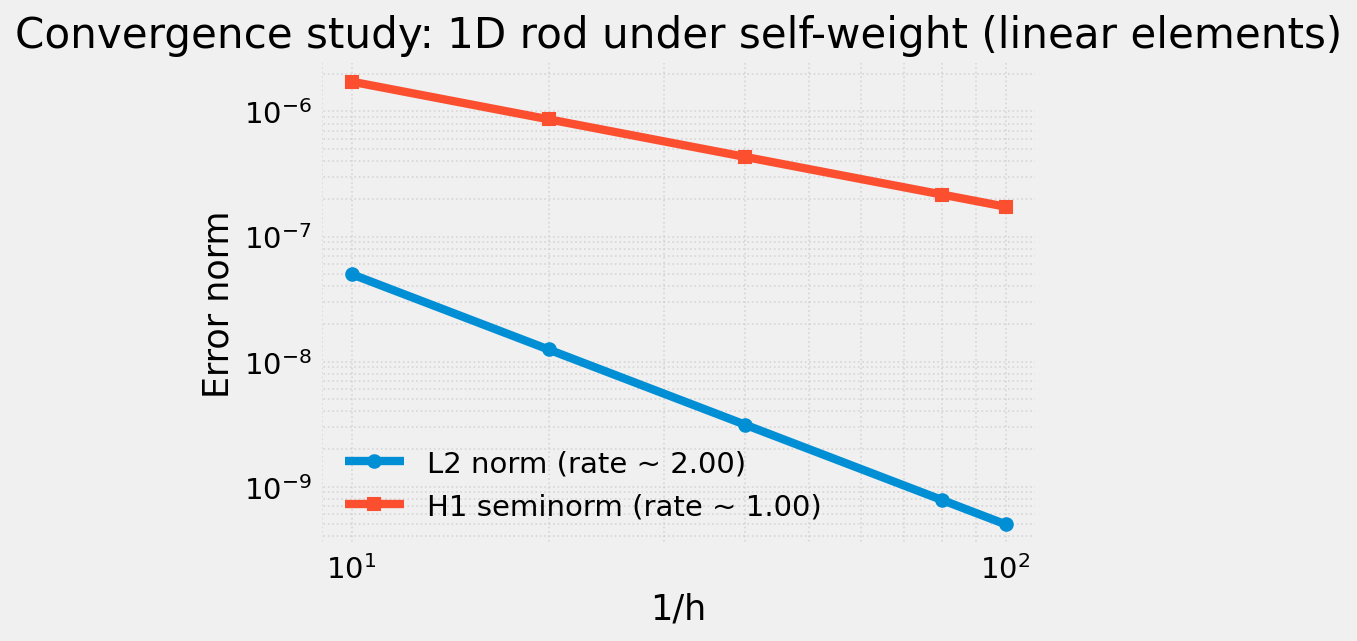

In [3]:
# ---------------------------------------------------------
# Exact solution for 1D rod under self-weight
# u(x)  = (rho*g/E) * (L*x - 0.5*x^2)
# du/dx = (rho*g/E) * (L - x)
# ---------------------------------------------------------
def exact_solution_1d(x):
    """
    x: array-like of shape (1,) or scalar
    Returns:
        u_exact    : scalar
        grad_exact : array of shape (1,) = [du/dx]
    """
    x_arr = np.asarray(x).reshape(-1)
    x_val = x_arr[0]  # since dim = 1

    coeff = rho * g / E
    u_exact = coeff * (L * x_val - 0.5 * x_val**2)
    grad_exact = np.array([coeff * (L - x_val)])  # shape (1,)

    return u_exact, grad_exact

# ---------------------------------------------------------
# Convergence study
# ---------------------------------------------------------

plt.style.use("fivethirtyeight")

# Choose element counts (refinement levels)
element_counts = [10, 20, 40, 80, 100]

inv_h = []
err_L2 = []
err_H1 = []

for ne in element_counts:
    # Build mesh
    coord, connectivity = build_bar_mesh(num_elements=ne, length=L)

    # Essential BC: top end fixed u(0) = 0 at node 1
    constraints = np.array([[1, 1, 0.0]], dtype=float)

    # Solve linear elasticity in 1D
    U = Driver_LE(
        connectivity,
        constraints,
        coord,
        medium_set,
        dim=1,
        dofs_per_node=1,
        EleType="L2",
        load_type=load_type,
        NCons=constraints.shape[0],
        Nele=connectivity.shape[0],
        NGPTS=2,
    )

    # Compute L2 and H1 errors using the strict Calculate_Error
    l2_err, h1_err = Calculate_Error(
        connectivity,
        coord,
        EleType="L2",
        NGPTS=2,
        U=U,
        get_exact_solution=exact_solution_1d,
        verbose=False,
    )

    err_L2.append(l2_err)
    err_H1.append(h1_err)

    # In 1D, h = L / ne  =>  1/h = ne / L
    inv_h.append(ne / L)

# Convert to arrays
inv_h = np.array(inv_h, dtype=float)
err_L2 = np.array(err_L2, dtype=float)
err_H1 = np.array(err_H1, dtype=float)

# Compute global slopes (least-squares fit in log-log space)
p_L2 = np.polyfit(np.log(inv_h), np.log(err_L2), 1)[0]
p_H1 = np.polyfit(np.log(inv_h), np.log(err_H1), 1)[0]

# ---------------------------------------------------------
# Pretty print convergence table & local rates (ASCII only)
# ---------------------------------------------------------
h_vals = L / np.array(element_counts, dtype=float)

print("=" * 80)
print("Convergence table: 1D rod under self-weight (linear elements)")
print("-" * 80)
header = (
    f"{'Nele':>6} | {'h':>10} | {'1/h':>10} | "
    f"{'L2 error':>12} | {'H1 error':>12}"
)
print(header)
print("-" * 80)

for ne, h, invh, eL2, eH1 in zip(element_counts, h_vals, inv_h, err_L2, err_H1):
    print(
        f"{ne:6d} | "
        f"{h:10.4e} | "
        f"{invh:10.4e} | "
        f"{eL2:12.4e} | "
        f"{eH1:12.4e}"
    )

print("-" * 80)

# Local (pairwise) convergence rates between consecutive meshes
local_rates_L2 = []
local_rates_H1 = []
for i in range(len(element_counts) - 1):
    # rate ≈ log(e_i / e_{i+1}) / log(h_i / h_{i+1})
    rL2 = np.log(err_L2[i] / err_L2[i + 1]) / np.log(h_vals[i] / h_vals[i + 1])
    rH1 = np.log(err_H1[i] / err_H1[i + 1]) / np.log(h_vals[i] / h_vals[i + 1])
    local_rates_L2.append(rL2)
    local_rates_H1.append(rH1)

print("Local convergence rates (between consecutive meshes):")
print(f"{'Interval':>12} | {'L2 rate':>10} | {'H1 rate':>10}")
print("-" * 44)
for i in range(len(local_rates_L2)):
    label = f"{element_counts[i]}->{element_counts[i+1]}"
    print(
        f"{label:>12} | "
        f"{local_rates_L2[i]:10.4f} | "
        f"{local_rates_H1[i]:10.4f}"
    )

print("-" * 44)
print(
    f"Global fitted rates (log-log LS): "
    f"L2 ~ {abs(p_L2):.4f}, H1 ~ {abs(p_H1):.4f}"
)
print("=" * 80)

# ---------------------------------------------------------
# Plot convergence
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=150)
ax.loglog(inv_h, err_L2, "o-", label=f"L2 norm (rate ~ {abs(p_L2):.2f})")
ax.loglog(inv_h, err_H1, "s-", label=f"H1 seminorm (rate ~ {abs(p_H1):.2f})")

ax.set_xlabel("1/h")
ax.set_ylabel("Error norm")
ax.set_title("Convergence study: 1D rod under self-weight (linear elements)")
ax.grid(True, which="both", linestyle=":", linewidth=0.8, alpha=0.7)
ax.legend(frameon=False)

fig.tight_layout()
img_path = IMG_DIR / "rod_selfweight_convergence.png"
fig.savefig(img_path, bbox_inches="tight", dpi=300)
print(f"Saved convergence plot to {img_path}")
plt.show()


       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Saved stress comparison figure to DataFiles_LE\img\Problem1_5_Stress_Comparison_8_mesh_size.png


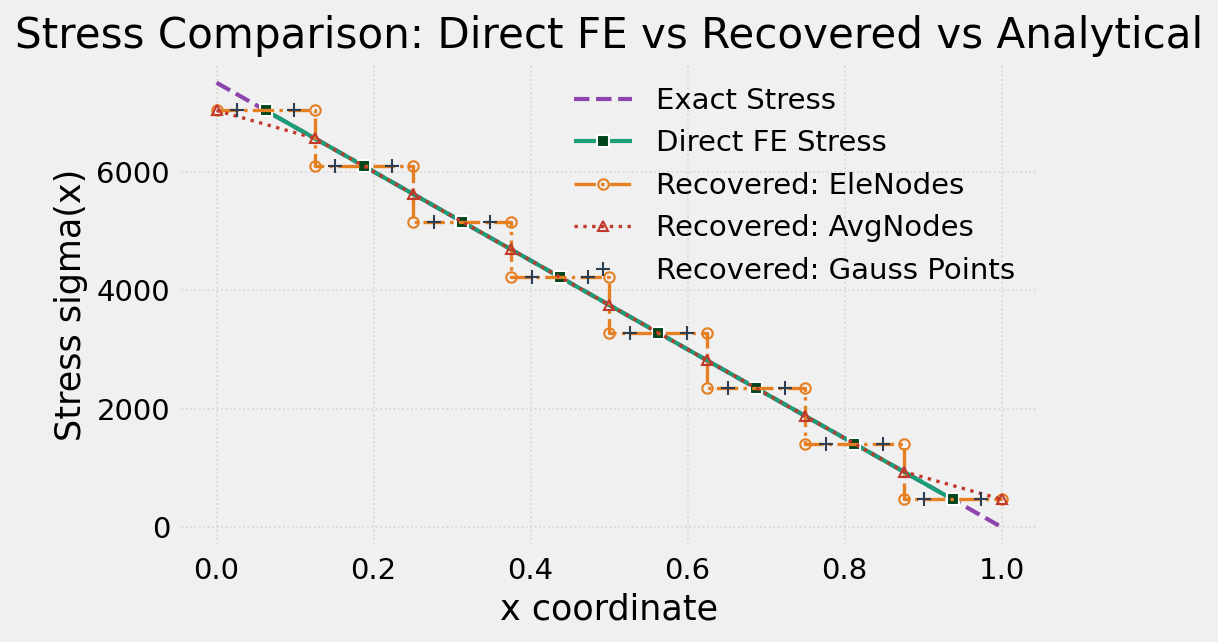

In [4]:
# ======================================================================
#  Problem 1.5 – Stress Comparison (Direct FE vs Recovered vs Analytical)
# ======================================================================

# ----------------------------------------------------------
#  Physical + material parameters
# ----------------------------------------------------------
L = 1.0
rho = 1500.0
g = 10.0
A = 0.5                     # cross-section area

# Effective body load parameter used in Driver_LE via Get_Rhob
# IMPORTANT: This is the same rhob that goes into the FE body force.
rhob = rho * g * A          # matches the reference figure range (0–7500)

E = 250e6
nu = 0.0

lambda_ = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu_ = E / (2.0 * (1.0 + nu))

medium_set = {
    "type": "Lame_params",
    "lambda": lambda_,
    "mu": mu_,
}

# Make sure your Get_Rhob has a "1D_gravity" branch that returns a (1,1) vector
# with entry -rhob when dim = 1.
load_type = {
    "case": "1D_gravity",
    "rhob": rhob,
}

dim = 1
dofs_per_node = 1
EleType = "L2"
NGPTS = 2

# ----------------------------------------------------------
#  Mesh + BCs (coarse mesh as in the provided figure)
# ----------------------------------------------------------
Nele = 8
NumNodes = Nele + 1
NCons = 1

Coord = np.zeros((NumNodes, 1))
Coord[:, 0] = np.linspace(0.0, L, NumNodes)

Connectivity = np.zeros((Nele, 2), dtype=int)
for e in range(Nele):
    Connectivity[e, :] = [e + 1, e + 2]   # 1-based element connectivity

Constraints = np.array([[1, 1, 0.0]], dtype=float)  # u(0) = 0

# ----------------------------------------------------------
#  Solve FEM displacement
# ----------------------------------------------------------
U = Driver_LE(
    Connectivity,
    Constraints,
    Coord,
    medium_set,
    dim,
    dofs_per_node,
    EleType,
    load_type,
    NCons,
    Nele,
    NGPTS,
)

# ----------------------------------------------------------
#  1. Analytical "stress": sigma_exact(x) = rhob * (L - x)
#     (This is axially the same quantity as the reference figure.)
# ----------------------------------------------------------
x_exact = Coord[:, 0]
sigma_exact = rhob * (L - x_exact)

# ----------------------------------------------------------
#  2. Direct FE Stress: sigma = E * du/dx on each element
# ----------------------------------------------------------
sigma_direct = np.zeros(Nele)

for e in range(Nele):
    i, j = e, e + 1
    dx = Coord[j, 0] - Coord[i, 0]
    du = U[j, 0] - U[i, 0]
    strain = du / dx
    sigma_direct[e] = E * strain

x_direct = 0.5 * (Coord[:-1, 0] + Coord[1:, 0])  # element centers

# ----------------------------------------------------------
#  3. Stress Recovery Methods (GPT, EleNodes, AvgNodes)
# ----------------------------------------------------------
sigma_GPT = Stress_Recovery(
    Connectivity, Coord, EleType,
    medium_set, NGPTS, "GPT", U
)

sigma_EleNodes = Stress_Recovery(
    Connectivity, Coord, EleType,
    medium_set, NGPTS, "EleNodes", U
)

sigma_AvgNodes = Stress_Recovery(
    Connectivity, Coord, EleType,
    medium_set, NGPTS, "AvgNodes", U
)

# ----------------------------------------------------------
#  Plotting in my usual style and color scheme
# ----------------------------------------------------------
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150)

# Exact (analytical) stress
ax.plot(
    x_exact,
    sigma_exact,
    linestyle="--",
    linewidth=2.0,
    color="#8E44AD",          # purple for analytical
    label="Exact Stress",
)

# Direct FE (piecewise)
ax.plot(
    x_direct,
    sigma_direct,
    marker="s",
    markersize=6,
    markerfacecolor="#00441B",
    markeredgecolor="white",
    linewidth=2.0,
    color="#1B9E77",          # green for numerical/FE
    label="Direct FE Stress",
)

# Recovered: EleNodes
ax.plot(
    sigma_EleNodes[:, 0],
    sigma_EleNodes[:, 1],
    linestyle="-.",
    marker="o",
    markersize=5,
    linewidth=1.6,
    markerfacecolor="none",
    markeredgecolor="#E67E22",
    color="#E67E22",
    label="Recovered: EleNodes",
)

# Recovered: AvgNodes
ax.plot(
    sigma_AvgNodes[:, 0],
    sigma_AvgNodes[:, 1],
    linestyle=":",
    marker="^",
    markersize=5,
    linewidth=1.6,
    markerfacecolor="none",
    markeredgecolor="#C0392B",
    color="#C0392B",
    label="Recovered: AvgNodes",
)

# Recovered: Gauss Points
ax.plot(
    sigma_GPT[:, 0],
    sigma_GPT[:, 1],
    linestyle="None",
    marker="+",
    markersize=7,
    color="#2C3E50",
    label="Recovered: Gauss Points",
)

ax.set_xlabel("x coordinate")
ax.set_ylabel("Stress sigma(x)")
ax.set_title("Stress Comparison: Direct FE vs Recovered vs Analytical")
ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)
ax.legend(frameon=False, loc="best")

fig.tight_layout()
img_path = IMG_DIR / f"Problem1_5_Stress_Comparison_{Nele}_mesh_size.png"
fig.savefig(img_path, bbox_inches="tight", dpi=300)
print(f"Saved stress comparison figure to {img_path}")
plt.show()


## 2. Bending of a Cantilever Beam

In [5]:



plt.style.use("fivethirtyeight")


# -------------------------------------------------------------------
# Mesh generator: Q8 cantilever, one element layer through the depth
# -------------------------------------------------------------------
def build_cantilever_q8_single_layer(
    n_elem_x: int,
    length: float = 1.0,
    height: float = 0.1,
    tol: float = 1e-12,
):
    """
    Build a single-row Q8 mesh for a cantilever beam.

    Geometry
    --------
    - Beam length:  [0, length]  along x
    - Beam depth:   [0, height]  along y
    - Unit width into the page (thickness = 1)

    Element type
    ------------
    - 8-node quadrilateral (Q8) without a center node.
    - Node numbering per element (counter-clockwise):
        1: bottom-left   (xL, 0)
        2: bottom-right  (xR, 0)
        3: top-right     (xR, H)
        4: top-left      (xL, H)
        5: mid-bottom    (xm, 0)
        6: mid-right     (xR, H/2)
        7: mid-top       (xm, H)
        8: mid-left      (xL, H/2)

    Boundary conditions
    -------------------
    - Fully fixed left edge: all nodes with x = 0 have ux = uy = 0.

    Parameters
    ----------
    n_elem_x : int
        Number of Q8 elements along the beam length.
    length : float
        Total beam length.
    height : float
        Beam depth.
    tol : float
        Tolerance for identifying the left boundary.

    Returns
    -------
    Coord : (NumNodes, 2) float
        Nodal coordinates [x, y].
    Connectivity : (Nele, 8) int
        Q8 connectivity with 1-based node ids.
    Constraints : (NCons, 3) float
        Dirichlet constraints: [node_id, dof_index, prescribed_value].
    """
    n_elem_x = int(n_elem_x)
    if n_elem_x < 1:
        raise ValueError("n_elem_x must be at least 1.")

    H = float(height)
    L = float(length)

    # Corner and mid-edge coordinates along x
    x_edges = np.linspace(0.0, L, n_elem_x + 1)          # corner x-coordinates
    x_mids = 0.5 * (x_edges[:-1] + x_edges[1:])         # mid-edge x-coordinates

    coord_list = []

    # Bottom edge: corners, then mids
    for x in x_edges:
        coord_list.append([x, 0.0])
    for x in x_mids:
        coord_list.append([x, 0.0])

    # Top edge: corners, then mids
    for x in x_edges:
        coord_list.append([x, H])
    for x in x_mids:
        coord_list.append([x, H])

    # Mid-depth vertical nodes at y = H/2, corner x positions
    for x in x_edges:
        coord_list.append([x, 0.5 * H])

    Coord = np.array(coord_list, dtype=float)

    # Build a coordinate-to-id map (1-based ids)
    coord_to_id = {tuple(pt): i + 1 for i, pt in enumerate(Coord)}

    # Connectivity: one row of Q8 elements along x
    Connectivity = []
    for i in range(n_elem_x):
        xL = x_edges[i]
        xR = x_edges[i + 1]
        xm = 0.5 * (xL + xR)

        # Corners
        n1 = coord_to_id[(xL, 0.0)]      # bottom-left
        n2 = coord_to_id[(xR, 0.0)]      # bottom-right
        n3 = coord_to_id[(xR, H)]        # top-right
        n4 = coord_to_id[(xL, H)]        # top-left

        # Mids
        n5 = coord_to_id[(xm, 0.0)]      # mid-bottom
        n6 = coord_to_id[(xR, 0.5 * H)]  # mid-right
        n7 = coord_to_id[(xm, H)]        # mid-top
        n8 = coord_to_id[(xL, 0.5 * H)]  # mid-left

        Connectivity.append([n1, n2, n3, n4, n5, n6, n7, n8])

    Connectivity = np.array(Connectivity, dtype=int)

    # Dirichlet constraints on the left edge (x = 0)
    left_nodes = [
        idx + 1
        for idx, (x, y) in enumerate(Coord)
        if abs(x - 0.0) < tol
    ]
    Constraints_list = []
    for node_id in left_nodes:
        Constraints_list.append([node_id, 1, 0.0])  # fix ux
        Constraints_list.append([node_id, 2, 0.0])  # fix uy
    Constraints = np.array(Constraints_list, dtype=float)

    # Informative printout
    print("=" * 68)
    print("Q8 Cantilever Mesh Summary")
    print("-" * 68)
    print(f"  Number of elements along length (n_elem_x): {n_elem_x}")
    print(f"  Beam length L = {L:.3f}, depth H = {H:.3f}")
    print(f"  Total nodes      : {Coord.shape[0]}")
    print(f"  Total elements   : {Connectivity.shape[0]}")
    print(f"  Dirichlet entries: {Constraints.shape[0]} "
          f"(fixed nodes on left edge: {left_nodes})")
    print("=" * 68 + "\n")

    return Coord, Connectivity, Constraints


Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 2
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 13
  Total elements   : 2
  Dirichlet entries: 6 (fixed nodes on left edge: [1, 6, 11])

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 4
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 23
  Total elements   : 4
  Dirichlet entries: 6 (fixed nodes on left edge: [1,

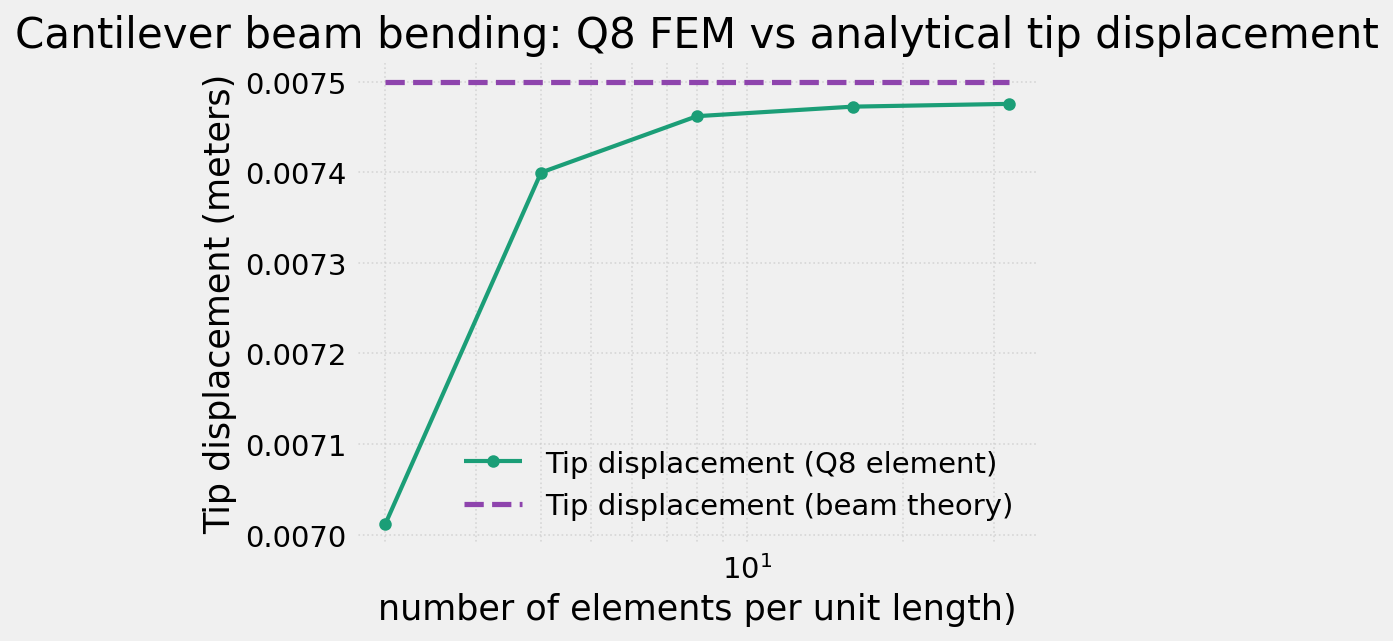

In [6]:
# -------------------------------------------------------------------
# Analytical tip deflection for a cantilever under uniform load
# -------------------------------------------------------------------
def cantilever_tip_deflection_uniform_load(E: float, I: float, q: float, L: float) -> float:
    """
    Euler–Bernoulli beam formula for a cantilever under uniform load q:

        v_tip = q * L^4 / (8 * E * I)

    Here we return a negative value for downward deflection.
    """
    return - q * L**4 / (8.0 * E * I)


# -------------------------------------------------------------------
# Physical and material parameters
# -------------------------------------------------------------------
L = 1.0   # beam length
H = 0.1   # beam depth
b = 1.0   # unit width (into the page)

rho = 1000.0          # density
g = 10.0              # gravity
rhob = rho * g        # body-force magnitude (per unit volume)

E = 200e6             # Young's modulus
nu = 0.1              # Poisson's ratio

# Lame parameters for your LE kernel
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
mu_ = E / (2 * (1 + nu))

medium_set = {
    "type": "Lame_params",
    "lambda": lambda_,
    "mu": mu_,
}

# Body force case: 2D gravity
load_type = {
    "case": "2D_gravity",
    "rhob": rhob,
}

dim = 2
dofs_per_node = 2
EleType = "Q8"
NGPTS = 3  # 3x3 Gauss rule is sufficient for Q8 in this setting

# Cross-sectional properties for beam theory
A = b * H
I = b * H**3 / 12.0
q_line = rhob * A                     # uniform load per unit length
v_tip_exact = cantilever_tip_deflection_uniform_load(E, I, q_line, L)


# -------------------------------------------------------------------
# 2.2–2.3: Solve on a hierarchy of meshes and compare tip displacement
# -------------------------------------------------------------------
mesh_counts = [2, 4, 8, 16, 32]   # elements along length

h_vals = []
inv_h_vals = []
tip_FE = []
tip_exact_list = []
tip_error = []

tol = 1e-10

for n_elem_x in mesh_counts:
    # (2.1) Mesh and data
    Coord, Connectivity, Constraints = build_cantilever_q8_single_layer(
        n_elem_x=n_elem_x,
        length=L,
        height=H,
    )

    Nele = Connectivity.shape[0]
    NCons = Constraints.shape[0]

    # (2.2) Solve linear elasticity with your driver
    U = Driver_LE(
        Connectivity,
        Constraints,
        Coord,
        medium_set,
        dim,
        dofs_per_node,
        EleType,
        load_type,
        NCons,
        Nele,
        NGPTS,
    )  # U: (NumNodes, 2)

    # Identify the "tip" node at (L, H/2)
    tip_candidates = np.where(
        (np.abs(Coord[:, 0] - L) < tol)
        & (np.abs(Coord[:, 1] - 0.5 * H) < tol)
    )[0]

    if tip_candidates.size != 1:
        raise RuntimeError(
            f"Expected exactly one tip node at (L, H/2); "
            f"found indices {tip_candidates}."
        )

    tip_node = tip_candidates[0]
    v_tip_FE = U[tip_node, 1]  # vertical displacement at tip node

    # Mesh size measures
    h = L / n_elem_x
    inv_h = 1.0 / h

    h_vals.append(h)
    inv_h_vals.append(inv_h)
    tip_FE.append(v_tip_FE)
    tip_exact_list.append(v_tip_exact)
    tip_error.append(abs(v_tip_FE - v_tip_exact))

# Convert to arrays for convenience
h_vals = np.array(h_vals, dtype=float)
inv_h_vals = np.array(inv_h_vals, dtype=float)
tip_FE = np.array(tip_FE, dtype=float)
tip_exact_list = np.array(tip_exact_list, dtype=float)
tip_error = np.array(tip_error, dtype=float)

# -------------------------------------------------------------------
# Informative convergence table
# -------------------------------------------------------------------
border = "=" * 86
print(border)
print("Cantilever beam (Q8) – tip displacement comparison (uniform self-weight)")
print(border)
header = f"{'n_elem_x':>8} {'h=L/n':>10} {'1/h':>10} {'v_tip_FE':>15} {'v_tip_exact':>15} {'|error|':>15}"
print(header)
print("-" * len(header))

for n_elem_x, h, inv_h, v_fe, v_ex, err in zip(
    mesh_counts, h_vals, inv_h_vals, tip_FE, tip_exact_list, tip_error
):
    print(
        f"{n_elem_x:8d} "
        f"{h:10.4e} "
        f"{inv_h:10.4e} "
        f"{v_fe:15.6e} "
        f"{v_ex:15.6e} "
        f"{err:15.6e}"
    )

print(border + "\n")

# -------------------------------------------------------------------
# Plot: tip displacement vs 1/h (FE vs analytical)
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6.0, 4.5), dpi=150)

# FE tip displacement (absolute value for clearer comparison)
ax.plot(
    inv_h_vals,
    np.abs(tip_FE),
    "o-",
    linewidth=2.0,
    markersize=5,
    label="Tip displacement (Q8 element)",
    color="#1B9E77",
)

# Analytical tip displacement (constant line)
ax.hlines(
    y=abs(v_tip_exact),
    xmin=inv_h_vals.min(),
    xmax=inv_h_vals.max(),
    linestyles="--",
    linewidth=2.5,
    label="Tip displacement (beam theory)",
    color="#8E44AD",
)

ax.set_xscale("log")
ax.set_xlabel("number of elements per unit length)")
ax.set_ylabel("Tip displacement (meters)")
ax.set_title("Cantilever beam bending: Q8 FEM vs analytical tip displacement")
ax.grid(True, which="both", linestyle=":", linewidth=0.8, alpha=0.7)
ax.legend(frameon=False)

fig.tight_layout()
img_path = IMG_DIR / "cantilever_Q8_tip_displacement_vs_h.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")
print(f"Saved cantilever convergence plot to {img_path}")
plt.show()

Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 2
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 13
  Total elements   : 2
  Dirichlet entries: 6 (fixed nodes on left edge: [1, 6, 11])

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 4
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 23
  Total elements   : 4
  Dirichlet entries: 6 (fixed nodes on left edge: [1,

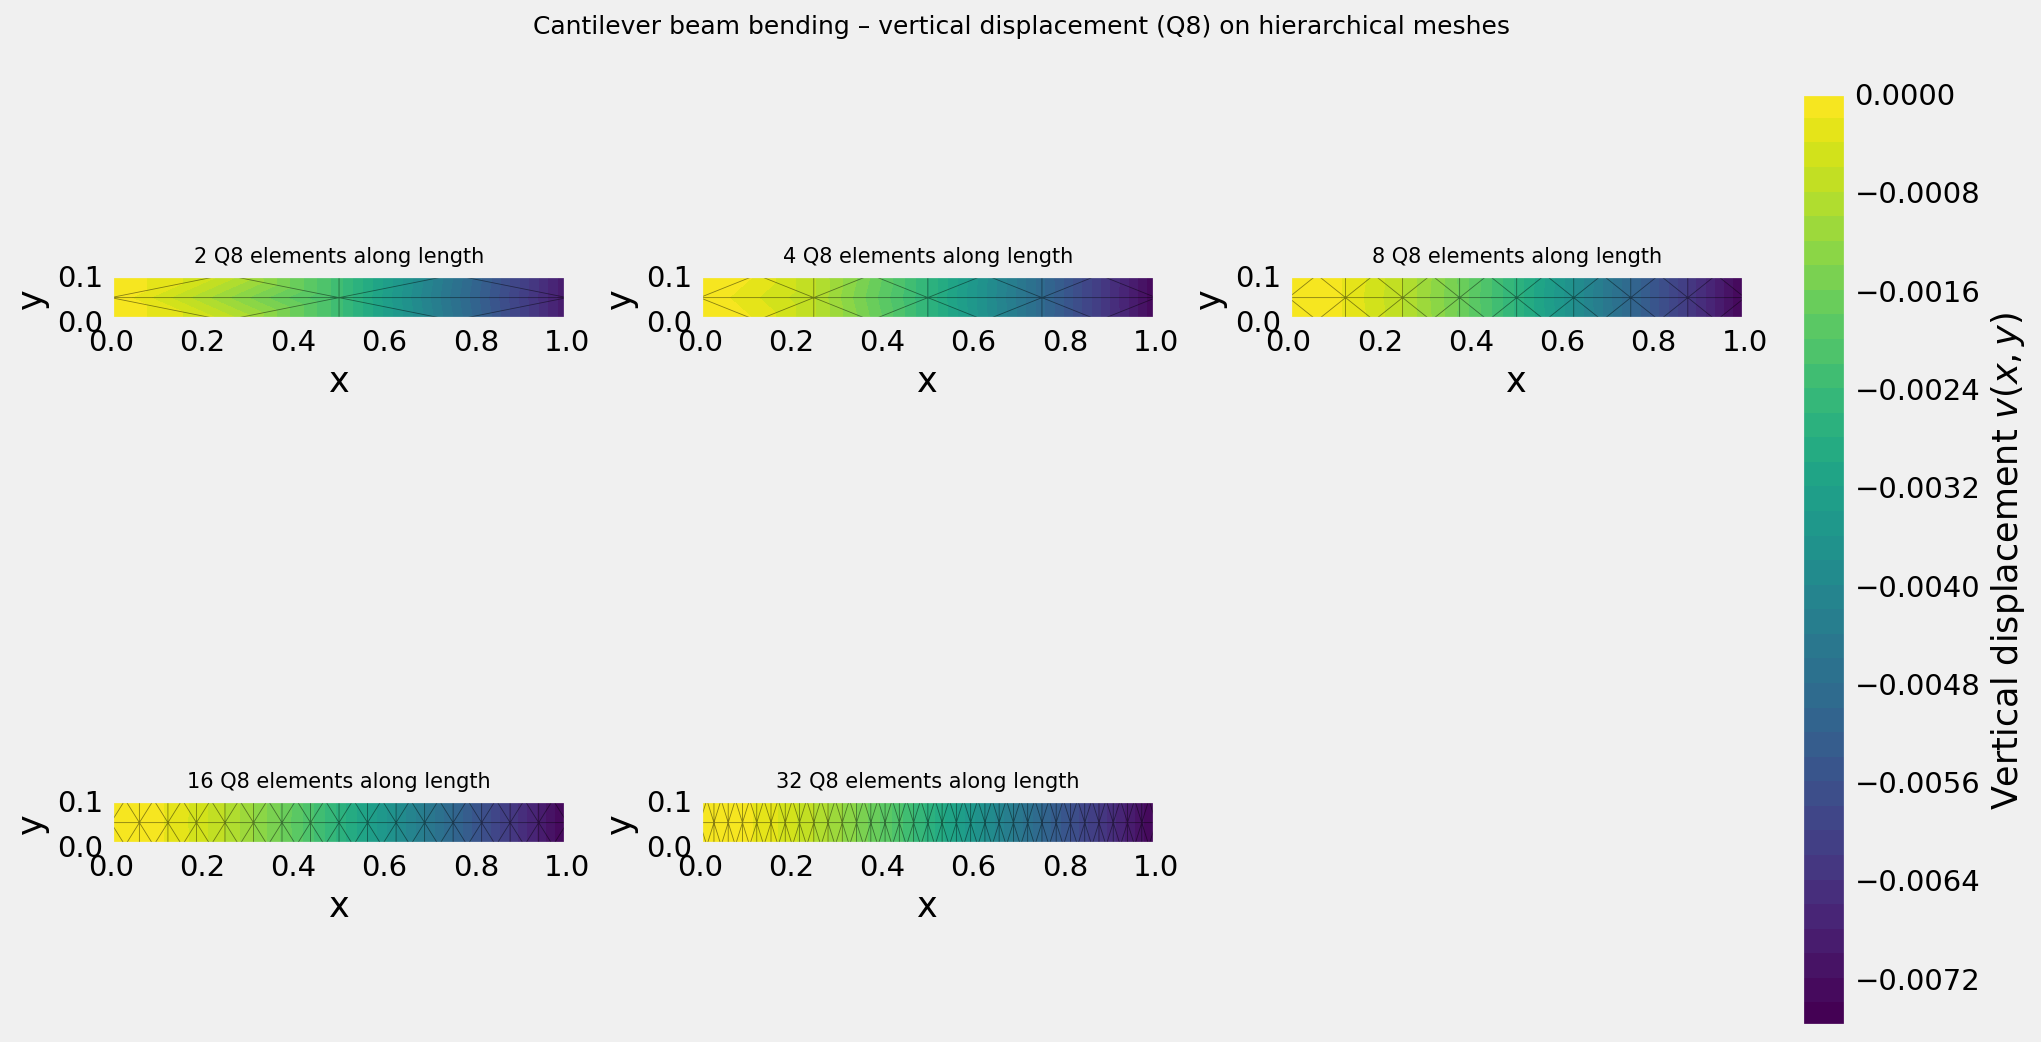

In [7]:
import matplotlib.tri as mtri

# ---------------------------------------------------------
# Displacement "surface" plots for a hierarchy of Q8 meshes
# ---------------------------------------------------------

mesh_counts = [2, 4, 8, 16, 32]   # elements along beam length

solutions = []    # to store (n_elem_x, Coord, Connectivity, U)
vmin = np.inf
vmax = -np.inf

# First pass: solve and find global color limits
for n_elem_x in mesh_counts:
    Coord, Connectivity, Constraints = build_cantilever_q8_single_layer(
        n_elem_x=n_elem_x,
        length=L,
        height=H,
    )

    Nele = Connectivity.shape[0]
    NCons = Constraints.shape[0]

    U = Driver_LE(
        Connectivity,
        Constraints,
        Coord,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q8",
        load_type=load_type,
        NCons=NCons,
        Nele=Nele,
        NGPTS=3,          # 3x3 Gaussian quadrature
    )

    v = U[:, 1]          # vertical displacement

    vmin = min(vmin, float(v.min()))
    vmax = max(vmax, float(v.max()))

    solutions.append((n_elem_x, Coord, Connectivity, U))

print(f"Global vertical displacement range across meshes: [{vmin:.4e}, {vmax:.4e}]")

# ---------------------------------------------------------
# Helper: build triangles for plotting from Q8 connectivity
# ---------------------------------------------------------
def q8_to_triangles_for_plot(connectivity: np.ndarray) -> np.ndarray:
    """
    Build a triangle list for plotting for a Q8 mesh.

    Q8 local node numbering (1-based indices):
        1: bottom-left, 2: bottom-right, 3: top-right, 4: top-left
        5: mid-bottom,  6: mid-right,    7: mid-top,  8: mid-left

    We subdivide each Q8 into 6 triangles using all 8 nodes.
    """
    tris = []
    for ele in range(connectivity.shape[0]):
        n1, n2, n3, n4, n5, n6, n7, n8 = connectivity[ele, :] - 1

        tris.extend([
            [n1, n5, n8],   # bottom-left corner
            [n5, n2, n6],   # bottom-right corner
            [n6, n3, n7],   # top-right corner
            [n7, n4, n8],   # top-left corner
            [n5, n6, n8],   # middle (left side)
            [n6, n7, n8],   # middle (right side)
        ])
    return np.array(tris, dtype=int)

# ---------------------------------------------------------
# Second pass: make subplots for each mesh level
# ---------------------------------------------------------
n_levels = len(solutions)
ncols = 3
nrows = int(np.ceil(n_levels / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4.5 * ncols, 3.5 * nrows),
    dpi=150,
    constrained_layout=True,
)

# axes might be 2D; flatten for easy indexing
axes = np.atleast_1d(axes).ravel()

for ax_idx, (n_elem_x, Coord, Connectivity, U) in enumerate(solutions):
    ax = axes[ax_idx]

    v = U[:, 1]  # vertical displacement field

    # Build triangulation for plotting
    triangles = q8_to_triangles_for_plot(Connectivity)
    triang = mtri.Triangulation(Coord[:, 0], Coord[:, 1], triangles=triangles)

    # Filled contour "surface"
    tcf = ax.tricontourf(
        triang,
        v,
        levels=40,
        vmin=vmin,
        vmax=vmax,
    )

    # Edge lines to show the mesh
    ax.triplot(triang, color="k", lw=0.4, alpha=0.45)

    ax.set_title(f"{n_elem_x} Q8 elements along length", fontsize=10)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

# Hide any unused axes (if mesh_counts does not fill grid)
for j in range(len(solutions), len(axes)):
    fig.delaxes(axes[j])

# Single shared colorbar
cbar = fig.colorbar(
    tcf,
    ax=axes.tolist(),
    shrink=0.9,
    pad=0.02,
)
cbar.set_label("Vertical displacement $v(x,y)$")

fig.suptitle(
    "Cantilever beam bending – vertical displacement (Q8) on hierarchical meshes",
    fontsize=12,
    y=1.02,
)

img_path = IMG_DIR / "cantilever_Q8_displacement_hierarchy.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")
print(f"Saved hierarchical displacement figure to {img_path}")
plt.show()


Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 2
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 13
  Total elements   : 2
  Dirichlet entries: 6 (fixed nodes on left edge: [1, 6, 11])

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 4
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 23
  Total elements   : 4
  Dirichlet entries: 6 (fixed nodes on left edge: [1,

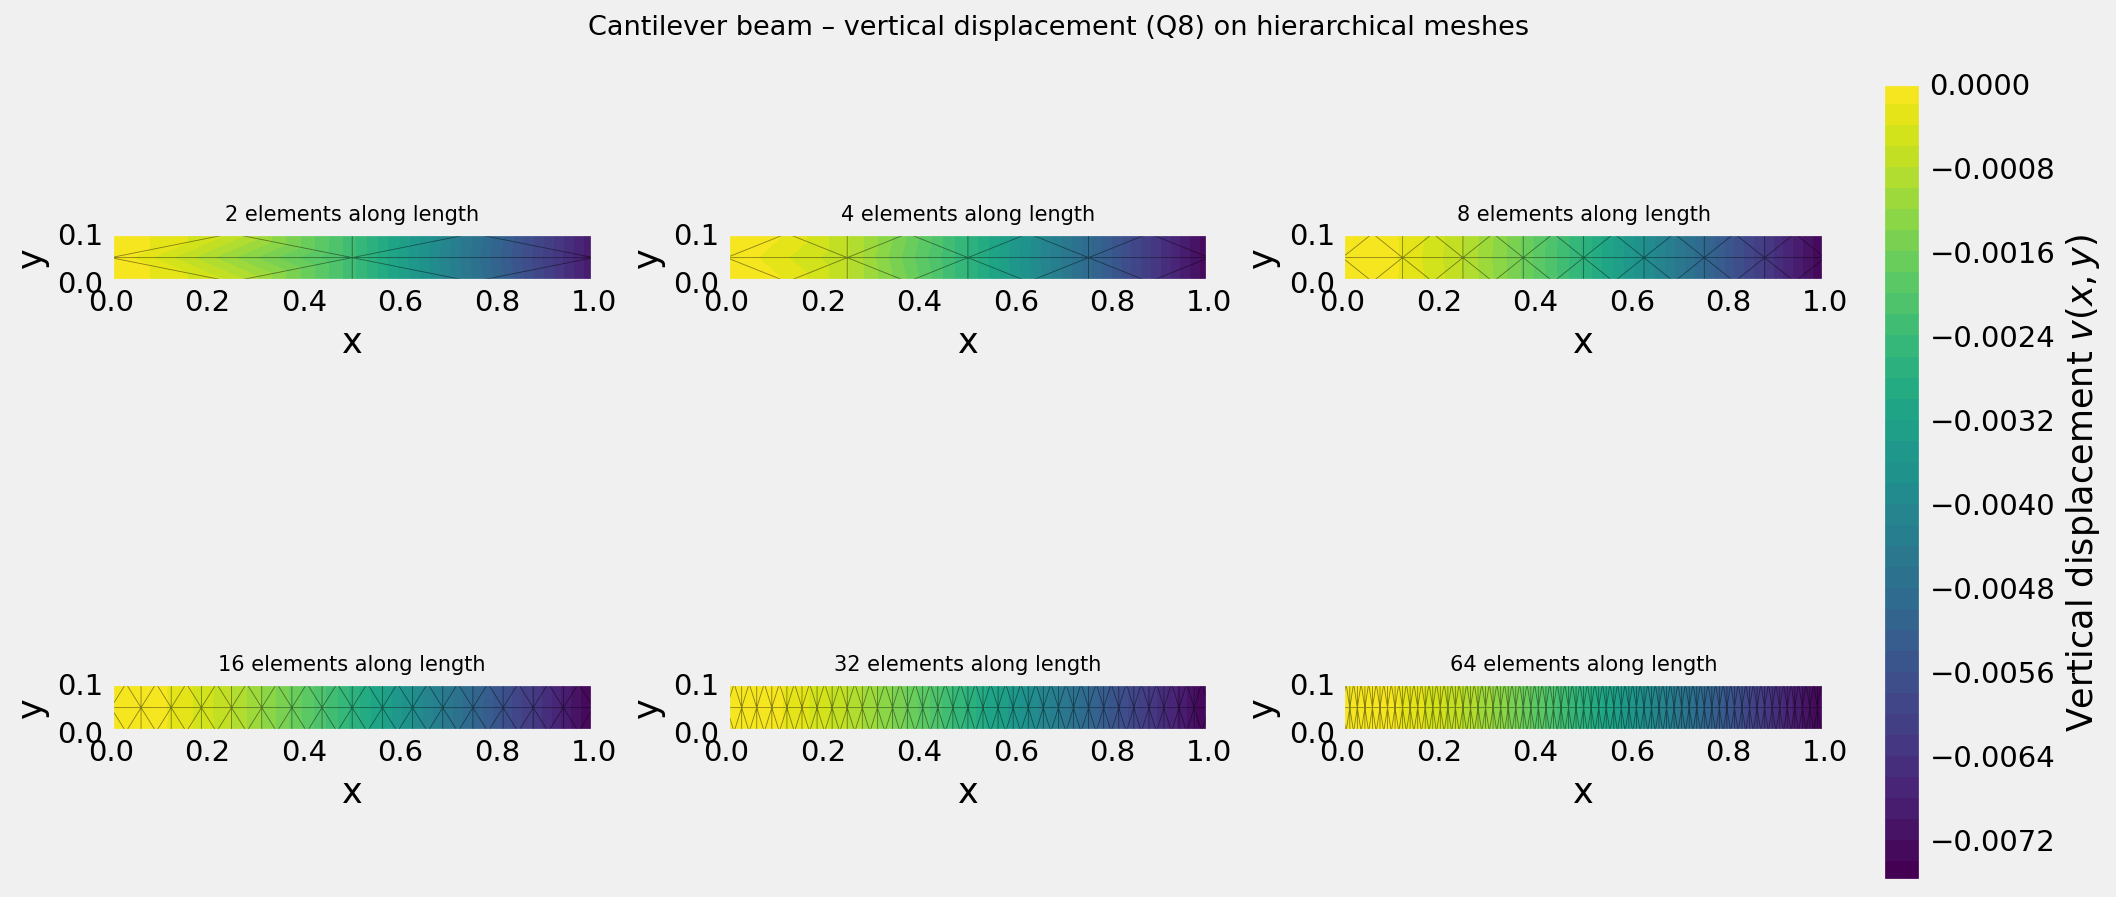

VTK file written to: DataFiles_LE\vtk\cantilever_Q8_2elems_displacement.vtk
VTK file written to: DataFiles_LE\vtk\cantilever_Q8_4elems_displacement.vtk
VTK file written to: DataFiles_LE\vtk\cantilever_Q8_8elems_displacement.vtk
VTK file written to: DataFiles_LE\vtk\cantilever_Q8_16elems_displacement.vtk
VTK file written to: DataFiles_LE\vtk\cantilever_Q8_32elems_displacement.vtk
VTK file written to: DataFiles_LE\vtk\cantilever_Q8_64elems_displacement.vtk


In [8]:
from Outputs.taiwo_write_vtk_file import write_vtk_unstructured

import matplotlib.tri as mtri

# ---------------------------------------------------------
# Displacement "surface" plots – 6 meshes, 2x3 layout
# ---------------------------------------------------------

# Optional: directory for VTK files
VTK_DIR = Path("DataFiles_LE/vtk")
VTK_DIR.mkdir(parents=True, exist_ok=True)

# Six refinement levels
mesh_counts = [2, 4, 8, 16, 32, 64]

solutions = []    # (n_elem_x, Coord, Connectivity, U)
vmin = np.inf
vmax = -np.inf

# First pass: solve and find global color limits
for n_elem_x in mesh_counts:
    Coord, Connectivity, Constraints = build_cantilever_q8_single_layer(
        n_elem_x=n_elem_x,
        length=L,
        height=H,
    )

    Nele = Connectivity.shape[0]
    NCons = Constraints.shape[0]

    U = Driver_LE(
        Connectivity,
        Constraints,
        Coord,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q8",
        load_type=load_type,
        NCons=NCons,
        Nele=Nele,
        NGPTS=3,    # 3x3 Gauss
    )

    v = U[:, 1]   # vertical displacement

    vmin = min(vmin, float(v.min()))
    vmax = max(vmax, float(v.max()))

    solutions.append((n_elem_x, Coord, Connectivity, U))

print(f"Global vertical displacement range across meshes: [{vmin:.4e}, {vmax:.4e}]")


def q8_to_triangles_for_plot(connectivity: np.ndarray) -> np.ndarray:
    """
    Build a triangle list for plotting from Q8 connectivity.

    Q8 local node numbering (1-based):
        1: bottom-left, 2: bottom-right, 3: top-right, 4: top-left
        5: mid-bottom,  6: mid-right,    7: mid-top,  8: mid-left

    We subdivide each Q8 into 6 triangles using all 8 nodes.
    """
    tris = []
    for ele in range(connectivity.shape[0]):
        n1, n2, n3, n4, n5, n6, n7, n8 = connectivity[ele, :] - 1

        tris.extend([
            [n1, n5, n8],   # bottom-left corner
            [n5, n2, n6],   # bottom-right corner
            [n6, n3, n7],   # top-right corner
            [n7, n4, n8],   # top-left corner
            [n5, n6, n8],   # middle (left-ish)
            [n6, n7, n8],   # middle (right-ish)
        ])
    return np.array(tris, dtype=int)


# Second pass: 2x3 subplot layout
n_levels = len(solutions)
nrows, ncols = 2, 3

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, 6),   # wider & taller
    dpi=150,
    constrained_layout=True,
)

axes = np.atleast_1d(axes).ravel()

for ax_idx, (n_elem_x, Coord, Connectivity, U) in enumerate(solutions):
    ax = axes[ax_idx]

    v = U[:, 1]  # vertical displacement

    # Triangulation for plotting
    triangles = q8_to_triangles_for_plot(Connectivity)
    triang = mtri.Triangulation(Coord[:, 0], Coord[:, 1], triangles=triangles)

    # Filled contour-like surface
    tcf = ax.tricontourf(
        triang,
        v,
        levels=40,
        vmin=vmin,
        vmax=vmax,
    )

    # Mesh edges
    ax.triplot(triang, color="k", lw=0.4, alpha=0.45)

    ax.set_title(f"{n_elem_x} elements along length", fontsize=10)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Let the beam fill the subplot (visually nicer than the true 10:1 aspect)
    #ax.set_aspect("auto")
    
    # Or to plot true slender beams
    ax.set_aspect("equal", adjustable="box")


    # Limit axes to the beam geometry
    ax.set_xlim(0.0, L)
    ax.set_ylim(0.0, H)

    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

# No unused axes because we used exactly 6 meshes for a 2x3 grid

# Shared colorbar
cbar = fig.colorbar(
    tcf,
    ax=axes.tolist(),
    shrink=0.9,
    pad=0.02,
)
cbar.set_label("Vertical displacement $v(x,y)$")

fig.suptitle(
    "Cantilever beam – vertical displacement (Q8) on hierarchical meshes",
    fontsize=13,
    y=1.02,
)

img_path = IMG_DIR / "cantilever_Q8_displacement_hierarchy_2x3.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")
print(f"Saved hierarchical displacement figure to {img_path}")
plt.show()



# ---------------------------------------------------------
# Export each mesh level to VTK for ParaView
# ---------------------------------------------------------
for n_elem_x, Coord, Connectivity, U in solutions:
    vtk_name = f"cantilever_Q8_{n_elem_x}elems_displacement"
    write_vtk_unstructured(
        connectivity=Connectivity,
        coord=Coord,
        data=U,                   # [ux, uy]
        ele_type="Q8",
        filename=vtk_name,
        directory=VTK_DIR,
        data_type="Vector",
        data_name="displacement",
    )



#### Comparison of Q8 and Q4 Elements

In [9]:
import numpy as np

def build_cantilever_q4_multi_layer(
    n_elem_x: int,
    n_elem_y: int,
    length: float = 1.0,
    height: float = 0.1,
    tol: float = 1e-12,
):
    """
    Build a structured Q4 mesh for a 2D cantilever beam on [0, length] x [0, height].

    - Left edge (x = 0) is fully clamped: ux = uy = 0.
    - Q4 connectivity is [bottom-left, bottom-right, top-right, top-left],
      consistent with your existing build_structured_q4.

    Parameters
    ----------
    n_elem_x : int
        Number of Q4 elements along the beam length.
    n_elem_y : int
        Number of Q4 elements through the beam depth (height).
    length : float
        Beam length in x-direction.
    height : float
        Beam depth/height in y-direction.
    tol : float
        Tolerance for boundary checks.

    Returns
    -------
    Coord : (NumNodes, 2) float array
        Nodal coordinates.
    Connectivity : (Nele, 4) int array
        Q4 connectivity (1-based node numbering).
    Constraints : (NCons, 3) float array
        Dirichlet constraints [node_id, dof_index, prescribed_value].
        Here: ux = uy = 0 on the left edge x = 0.
    """
    nx_nodes = n_elem_x + 1
    ny_nodes = n_elem_y + 1

    x = np.linspace(0.0, length, nx_nodes)
    y = np.linspace(0.0, height, ny_nodes)
    xx, yy = np.meshgrid(x, y, indexing="xy")

    Coord = np.column_stack((xx.ravel(), yy.ravel()))

    # Q4 connectivity (same pattern as your build_structured_q4)
    Connectivity = []
    for j in range(ny_nodes - 1):
        for i in range(nx_nodes - 1):
            n1 = j * nx_nodes + i + 1
            n2 = n1 + 1
            n3 = n2 + nx_nodes
            n4 = n1 + nx_nodes
            Connectivity.append([n1, n2, n3, n4])
    Connectivity = np.array(Connectivity, dtype=int)

    # Clamp the left edge: x = 0 => ux = 0, uy = 0
    Constraints = []
    for idx, (xi, yi) in enumerate(Coord, start=1):
        if abs(xi - 0.0) < tol:
            Constraints.append([idx, 1, 0.0])  # ux = 0
            Constraints.append([idx, 2, 0.0])  # uy = 0
    Constraints = np.array(Constraints, dtype=float)

    return Coord, Connectivity, Constraints


In [10]:
def find_mid_depth_tip_node(Coord, L, H, tol=1e-8):
    """
    Find the index (0-based) of the node at (x=L, y=H/2), or the closest one.

    Parameters
    ----------
    Coord : (NumNodes, 2)
        Nodal coordinates.
    L : float
        Beam length.
    H : float
        Beam height.
    tol : float
        Tolerance for exact search. If not found within tol, nearest node is used.

    Returns
    -------
    idx : int
        Index into Coord (0-based) of the chosen node.
    """
    Coord = np.asarray(Coord, dtype=float)
    x = Coord[:, 0]
    y = Coord[:, 1]

    target = np.array([L, 0.5 * H])

    # Try exact match within tolerance
    mask = (np.abs(x - target[0]) < tol) & (np.abs(y - target[1]) < tol)
    candidates = np.where(mask)[0]
    if candidates.size > 0:
        return int(candidates[0])

    # Fallback: nearest node in Euclidean distance
    d2 = np.sum((Coord - target) ** 2, axis=1)
    idx = int(np.argmin(d2))
    print(
        f"Warning: no exact node at (L, H/2); using nearest node with coords "
        f"{Coord[idx]} for tip deflection."
    )
    return idx


Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 2
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 13
  Total elements   : 2
  Dirichlet entries: 6 (fixed nodes on left edge: [1, 6, 11])

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 4
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 23
  Total elements   : 4
  Dirichlet entries: 6 (fixed nodes on left edge: [1,

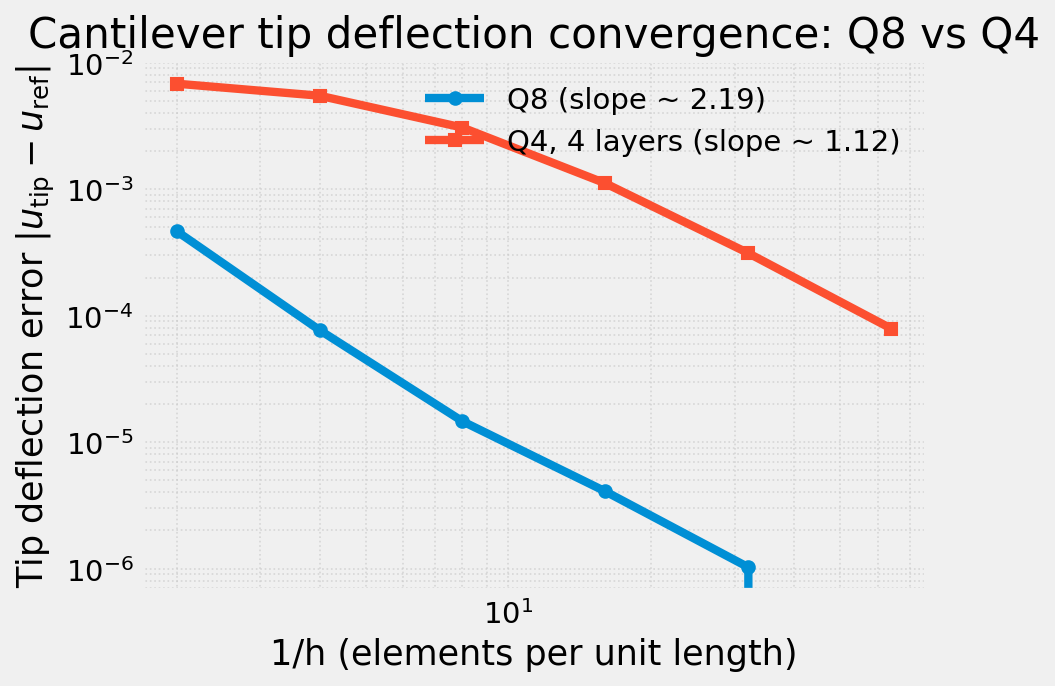

In [11]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

# -------------------------------------------
# Mesh refinement levels along the length
# -------------------------------------------
mesh_counts = [2, 4, 8, 16, 32, 64]

# Choose how many Q4 layers through the depth
n_elem_y_q4 = 4  

# Storage
q8_results = []   # (n_elem_x, dofs, u_tip)
q4_results = []   # (n_elem_x, n_elem_y_q4, dofs, u_tip)

# -------------------------------------------
# Solve with Q8 (single layer in depth)
# -------------------------------------------
for n_elem_x in mesh_counts:
    Coord_q8, Conn_q8, Cons_q8 = build_cantilever_q8_single_layer(
        n_elem_x=n_elem_x,
        length=L,
        height=H,
    )

    Nele_q8 = Conn_q8.shape[0]
    NCons_q8 = Cons_q8.shape[0]
    NumNodes_q8 = Coord_q8.shape[0]

    U_q8 = Driver_LE(
        Conn_q8,
        Cons_q8,
        Coord_q8,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q8",
        load_type=load_type,
        NCons=NCons_q8,
        Nele=Nele_q8,
        NGPTS=3,  # 3x3 Gauss for Q8
    )

    # Mid-depth tip node index
    tip_idx_q8 = find_mid_depth_tip_node(Coord_q8, L, H)
    u_tip_q8 = U_q8[tip_idx_q8, 1]   # vertical displacement

    total_dofs_q8 = NumNodes_q8 * 2
    free_dofs_q8 = total_dofs_q8 - NCons_q8  # each constraint fixes one dof

    q8_results.append((n_elem_x, free_dofs_q8, u_tip_q8))

# Use the finest Q8 mesh as "reference" tip displacement
u_tip_ref = q8_results[-1][2]
print(f"\nReference tip deflection (finest Q8, {mesh_counts[-1]} elems): {u_tip_ref:.6e}\n")

# -------------------------------------------
# Solve with Q4 (multiple layers in depth)
# -------------------------------------------
for n_elem_x in mesh_counts:
    Coord_q4, Conn_q4, Cons_q4 = build_cantilever_q4_multi_layer(
        n_elem_x=n_elem_x,
        n_elem_y=n_elem_y_q4,
        length=L,
        height=H,
    )

    Nele_q4 = Conn_q4.shape[0]
    NCons_q4 = Cons_q4.shape[0]
    NumNodes_q4 = Coord_q4.shape[0]

    U_q4 = Driver_LE(
        Conn_q4,
        Cons_q4,
        Coord_q4,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q4",
        load_type=load_type,
        NCons=NCons_q4,
        Nele=Nele_q4,
        NGPTS=2,  # 2x2 Gauss is standard for Q4
    )

    tip_idx_q4 = find_mid_depth_tip_node(Coord_q4, L, H)
    u_tip_q4 = U_q4[tip_idx_q4, 1]

    total_dofs_q4 = NumNodes_q4 * 2
    free_dofs_q4 = total_dofs_q4 - NCons_q4

    q4_results.append((n_elem_x, n_elem_y_q4, free_dofs_q4, u_tip_q4))

# -------------------------------------------
# Build convergence data (tip deflection error)
# -------------------------------------------
inv_h = []          # 1/h = n_elem_x / L
err_q8 = []         # |u_tip_q8 - u_ref|
err_q4 = []         # |u_tip_q4 - u_ref|

for (n_ex, dofs8, u8), (_, ny4, dofs4, u4) in zip(q8_results, q4_results):
    inv_h.append(n_ex / L)
    err_q8.append(abs(u8 - u_tip_ref))
    err_q4.append(abs(u4 - u_tip_ref))

inv_h = np.array(inv_h, dtype=float)
err_q8 = np.array(err_q8, dtype=float)
err_q4 = np.array(err_q4, dtype=float)

# Fit slopes on log-log scale (ignore the last point which is reference error ~ 0)
p_q8 = np.polyfit(np.log(inv_h[:-1]), np.log(err_q8[:-1] + 1e-30), 1)[0]
p_q4 = np.polyfit(np.log(inv_h[:-1]), np.log(err_q4[:-1] + 1e-30), 1)[0]

# -------------------------------------------
# Print summary table
# -------------------------------------------
border = "-" * 80
print(border)
print(f"{'Q8 vs Q4 Cantilever Tip Deflection Comparison':^80}")
print(border)
print(
    f"{'nel_x':>6} | {'dofs_Q8':>8} | {'u_tip_Q8':>14} | "
    f"{'dofs_Q4':>8} | {'u_tip_Q4':>14} | {'|u4-u_ref|':>12} | {'|u8-u_ref|':>12}"
)
print(border)
for (n_ex, dofs8, u8), (_, ny4, dofs4, u4), eh8, eh4 in zip(
    q8_results, q4_results, err_q8, err_q4
):
    print(
        f"{n_ex:6d} | {dofs8:8d} | {u8:14.6e} | "
        f"{dofs4:8d} | {u4:14.6e} | {eh4:12.4e} | {eh8:12.4e}"
    )
print(border)
print(f"Estimated convergence slope (Q8, tip deflection)  ~ {abs(p_q8):.2f}")
print(f"Estimated convergence slope (Q4, tip deflection)  ~ {abs(p_q4):.2f}")
print(border + "\n")

# -------------------------------------------
# Plot: error vs 1/h
# -------------------------------------------
fig, ax = plt.subplots(figsize=(6.5, 4.8), dpi=150)

ax.loglog(inv_h, err_q8, "o-", label=f"Q8 (slope ~ {abs(p_q8):.2f})")
ax.loglog(inv_h, err_q4, "s-", label=f"Q4, {n_elem_y_q4} layers (slope ~ {abs(p_q4):.2f})")

ax.set_xlabel("1/h (elements per unit length)")
ax.set_ylabel(r"Tip deflection error $|u_{\mathrm{tip}} - u_{\mathrm{ref}}|$")
ax.set_title("Cantilever tip deflection convergence: Q8 vs Q4")
ax.grid(True, which="both", linestyle=":", linewidth=0.8, alpha=0.7)
ax.legend(frameon=False)

fig.tight_layout()
img_path = IMG_DIR / "cantilever_Q8_vs_Q4_tip_convergence.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")
print(f"Saved Q8 vs Q4 convergence figure to {img_path}")
plt.show()


Cantilever beam – Q8 vs Q4 tip displacement for different depth discretizations
Q8 Cantilever Mesh Summary
--------------------------------------------------------------------
  Number of elements along length (n_elem_x): 2
  Beam length L = 1.000, depth H = 0.100
  Total nodes      : 13
  Total elements   : 2
  Dirichlet entries: 6 (fixed nodes on left edge: [1, 6, 11])

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Q8 : n_elem_x=  2,  tip v ≈ -7.011331e-03
[Q4 mesh] n_elem_x=  2, n_elem_y= 1  NumNodes=   6, Nele=   2, NCons=   4
       Quasi-static Linear Elasticity Simulation Status Report               
       Step

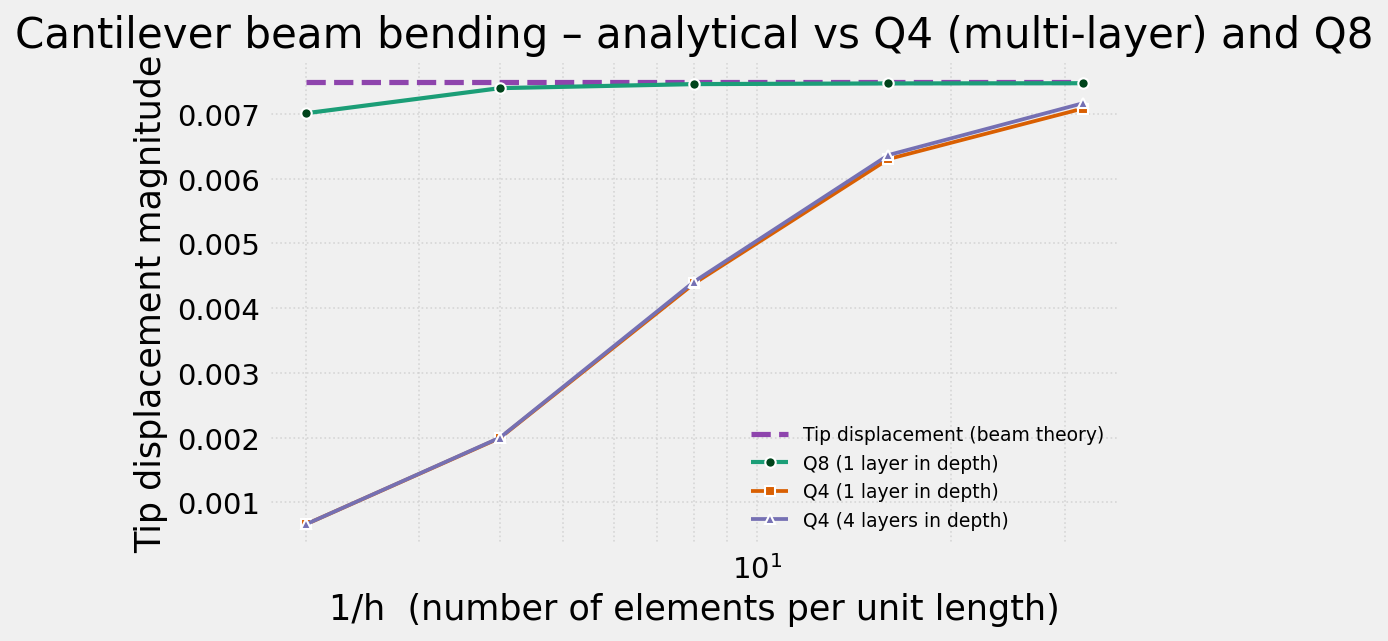

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Helper: Q4 cantilever mesh with multiple layers through depth
# -------------------------------------------------------------------
def build_cantilever_q4_multi_layer(
    n_elem_x: int,
    n_elem_y: int,
    length: float = 1.0,
    height: float = 0.1,
    tol: float = 1e-12,
):
    """
    Structured Q4 mesh for a rectangular cantilever beam:

        0 <= x <= length,  0 <= y <= height

    Left edge (x = 0) is fully clamped in both ux, uy.

    Parameters
    ----------
    n_elem_x : int
        Number of Q4 elements along the beam length.
    n_elem_y : int
        Number of Q4 elements through the depth.
    length : float
        Beam length L.
    height : float
        Beam depth H.
    tol : float
        Tolerance for identifying the clamped edge.

    Returns
    -------
    Coord : (NumNodes, 2) float
        Nodal coordinates [x, y].
    Connectivity : (Nele, 4) int
        Q4 connectivity (1-based, counter-clockwise).
    Constraints : (NCons, 3) float
        Dirichlet constraints [node_id, dof, value] for ux = uy = 0 on x=0.
    """
    # Nodal grid
    nx_nodes = n_elem_x + 1
    ny_nodes = n_elem_y + 1

    x = np.linspace(0.0, length, nx_nodes)
    y = np.linspace(0.0, height, ny_nodes)
    xx, yy = np.meshgrid(x, y, indexing="xy")
    Coord = np.column_stack((xx.ravel(), yy.ravel()))

    # Connectivity (counter-clockwise: 1-2-3-4)
    connectivity = []
    for j in range(ny_nodes - 1):
        for i in range(nx_nodes - 1):
            n1 = j * nx_nodes + i + 1
            n2 = n1 + 1
            n3 = n2 + nx_nodes
            n4 = n1 + nx_nodes
            connectivity.append([n1, n2, n3, n4])

    Connectivity = np.array(connectivity, dtype=int)

    # Clamp left edge: all nodes with x ≈ 0 have ux=0 and uy=0
    Constraints = []
    for nid, (xi, yi) in enumerate(Coord, start=1):
        if abs(xi - 0.0) < tol:
            Constraints.append([nid, 1, 0.0])  # ux
            Constraints.append([nid, 2, 0.0])  # uy

    Constraints = np.array(Constraints, dtype=float)

    # Basic sanity prints (optional)
    print(
        f"[Q4 mesh] n_elem_x={n_elem_x:3d}, n_elem_y={n_elem_y:2d}  "
        f"NumNodes={Coord.shape[0]:4d}, Nele={Connectivity.shape[0]:4d}, "
        f"NCons={Constraints.shape[0]:4d}"
    )

    return Coord, Connectivity, Constraints


# -------------------------------------------------------------------
# Helper: extract vertical tip displacement at (L, H/2) (or closest)
# -------------------------------------------------------------------
def get_tip_vertical_displacement(
    Coord: np.ndarray,
    U: np.ndarray,
    L: float,
    H: float,
    tol: float = 1e-10,
) -> float:
    """
    Find the node on the free end (x ~ L) whose y is closest to H/2
    and return its vertical displacement (second DOF).
    """
    x = Coord[:, 0]
    y = Coord[:, 1]

    # Nodes on (or very close to) the free edge
    right_nodes = np.where(np.abs(x - L) < tol)[0]
    if right_nodes.size == 0:
        # Fallback: take nodes with maximum x
        max_x = x.max()
        right_nodes = np.where(np.abs(x - max_x) < 1e-8)[0]

    target_y = 0.5 * H
    j = np.argmin(np.abs(y[right_nodes] - target_y))
    tip_node = right_nodes[j]

    return float(U[tip_node, 1])  # vertical displacement


# -------------------------------------------------------------------
# Q8 + Q4 (multi-layer) tip-displacement comparison
# -------------------------------------------------------------------

# Mesh refinements along the length
mesh_counts = [2, 4, 8, 16, 32]

# Q4 layer counts through the depth
q4_layers_list = [1, 4]   # you can tweak these

# Storage
inv_h_vals = []
tip_q8 = []
tip_q4_layers = {ny: [] for ny in q4_layers_list}

dim = 2
dofs_per_node = 2
NGPTS_Q8 = 3
NGPTS_Q4 = 3  # 3x3 is safe for Q4 as well

tol = 1e-10

print("=" * 90)
print("Cantilever beam – Q8 vs Q4 tip displacement for different depth discretizations")
print("=" * 90)

for n_elem_x in mesh_counts:
    h = L / n_elem_x
    inv_h = 1.0 / h
    inv_h_vals.append(inv_h)

    # ---------------- Q8 (single layer through depth) ----------------
    Coord8, Conn8, Cons8 = build_cantilever_q8_single_layer(
        n_elem_x=n_elem_x,
        length=L,
        height=H,
    )

    Nele8 = Conn8.shape[0]
    NCons8 = Cons8.shape[0]

    U8 = Driver_LE(
        Conn8,
        Cons8,
        Coord8,
        medium_set,
        dim,
        dofs_per_node,
        "Q8",
        load_type,
        NCons8,
        Nele8,
        NGPTS_Q8,
    )

    v_tip_q8 = get_tip_vertical_displacement(Coord8, U8, L, H, tol=tol)
    tip_q8.append(v_tip_q8)

    print(f"Q8 : n_elem_x={n_elem_x:3d},  tip v ≈ {v_tip_q8: .6e}")

    # ---------------- Q4 (several layers through depth) --------------
    for n_elem_y in q4_layers_list:
        Coord4, Conn4, Cons4 = build_cantilever_q4_multi_layer(
            n_elem_x=n_elem_x,
            n_elem_y=n_elem_y,
            length=L,
            height=H,
        )

        Nele4 = Conn4.shape[0]
        NCons4 = Cons4.shape[0]

        U4 = Driver_LE(
            Conn4,
            Cons4,
            Coord4,
            medium_set,
            dim,
            dofs_per_node,
            "Q4",
            load_type,
            NCons4,
            Nele4,
            NGPTS_Q4,
        )

        v_tip_q4 = get_tip_vertical_displacement(Coord4, U4, L, H, tol=tol)
        tip_q4_layers[n_elem_y].append(v_tip_q4)

        print(
            f"Q4 : n_elem_x={n_elem_x:3d}, n_elem_y={n_elem_y:2d}, "
            f"tip v ≈ {v_tip_q4: .6e}"
        )

print("=" * 90)

inv_h_vals = np.array(inv_h_vals, dtype=float)
tip_q8 = np.array(tip_q8, dtype=float)

# -------------------------------------------------------------------
# Plot: analytical vs Q8 vs multiple Q4 curves
# -------------------------------------------------------------------
plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(figsize=(7.0, 4.5), dpi=150)

# Analytical constant line
ax.hlines(
    y=abs(v_tip_exact),
    xmin=inv_h_vals.min(),
    xmax=inv_h_vals.max(),
    linestyles="--",
    linewidth=2.5,
    label="Tip displacement (beam theory)",
    color="#8E44AD",
)

# Q8 curve
ax.plot(
    inv_h_vals,
    np.abs(tip_q8),
    "o-",
    linewidth=2.0,
    markersize=5,
    label="Q8 (1 layer in depth)",
    color="#1B9E77",
    markerfacecolor="#00441B",
    markeredgecolor="white",
)

# Q4 curves for different numbers of layers
q4_colors = ["#D95F02", "#7570B3", "#E7298A"]
q4_markers = ["s", "^", "v"]

for (n_elem_y, color, marker) in zip(q4_layers_list, q4_colors, q4_markers):
    vals = np.abs(np.array(tip_q4_layers[n_elem_y], dtype=float))
    label = f"Q4 ({n_elem_y} layer{'s' if n_elem_y > 1 else ''} in depth)"
    ax.plot(
        inv_h_vals,
        vals,
        marker + "-",
        linewidth=1.8,
        markersize=5,
        label=label,
        color=color,
        markerfacecolor=color,
        markeredgecolor="white",
    )

ax.set_xscale("log")
ax.set_xlabel("1/h  (number of elements per unit length)")
ax.set_ylabel("Tip displacement magnitude")
ax.set_title("Cantilever beam bending – analytical vs Q4 (multi-layer) and Q8")
ax.grid(True, which="both", linestyle=":", linewidth=0.8, alpha=0.7)
ax.legend(frameon=False, fontsize=9)

fig.tight_layout()
img_path = IMG_DIR / "cantilever_Q4_Q8_tip_displacement_comparison.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")
print(f"Saved Q4/Q8 tip-displacement comparison plot to {img_path}")
plt.show()


3. Modified Lame Problem

In [13]:
import numpy as np

ri = 0.1
ro = 1.0
u0 = 0.05

A = u0 * ro / (ro**2 - ri**2)
B = -A * ri**2

def exact_solution_thick_cylinder(x_vec: np.ndarray):
    """
    Exact displacement field for the modified Lamé thick cylinder,
    returned in Cartesian components + gradient.

    Parameters
    ----------
    x_vec : array_like, shape (2,)
        Physical point [x, y].

    Returns
    -------
    u_exact : ndarray, shape (2,)
        [u_x, u_y] at x.
    grad_exact : ndarray, shape (2, 2)
        [[du_x/dx, du_x/dy],
         [du_y/dx, du_y/dy]] at x.
    """
    x, y = float(x_vec[0]), float(x_vec[1])
    r = np.sqrt(x**2 + y**2)

    # radial displacement and g(r) = u_r / r
    ur = A * r + B / r
    g = ur / r                        # = A + B / r**2
    gprime = -2.0 * B / r**3          # derivative of g w.r.t r

    # Cartesian components
    ux = g * x
    uy = g * y

    # Gradient components
    dux_dx = g + (x**2 / r) * gprime
    dux_dy = (x * y / r) * gprime
    duy_dx = dux_dy
    duy_dy = g + (y**2 / r) * gprime

    u_exact = np.array([ux, uy])
    grad_exact = np.array([[dux_dx, dux_dy],
                           [duy_dx, duy_dy]])
    return u_exact, grad_exact


In [14]:
import numpy as np
import math

def generate_Q4_thick_cylinder_mesh(
    ri=0.1,
    ro=1.0,
    Nr=4,
    Ntheta=16,
    u0=0.05,
    tol=1e-10,
):
    """
    Structured Q4 mesh for a full annulus ri <= r <= ro, 0 <= theta < 2pi.

    Node order in each quad matches the Q4 reference:
        1: inner,  smaller theta   (bottom-left in local coords)
        2: outer,  smaller theta   (bottom-right)
        3: outer,  larger  theta   (top-right)
        4: inner,  larger  theta   (top-left)
    """

    # 1) Polar grid
    r_vals = np.linspace(ri, ro, Nr + 1)                   # j = 0..Nr
    theta_vals = np.linspace(0.0, 2.0*math.pi, Ntheta, endpoint=False)

    NumNodes = (Nr + 1) * Ntheta
    Coord = np.zeros((NumNodes, 2))

    def nid(j, k):
        return j * Ntheta + k   # 0-based index

    for j in range(Nr + 1):
        r = r_vals[j]
        for k in range(Ntheta):
            th = theta_vals[k]
            idx = nid(j, k)
            Coord[idx, 0] = r * math.cos(th)
            Coord[idx, 1] = r * math.sin(th)

    # 2) CONNECTIVITY (Q4, CCW orientation)
    Nele = Nr * Ntheta
    Connectivity = np.zeros((Nele, 4), dtype=int)

    e = 0
    for j in range(Nr):
        for k in range(Ntheta):
            kp1 = (k + 1) % Ntheta  # wrap-around

            # CCW: inner-θk -> outer-θk -> outer-θk+1 -> inner-θk+1
            n1 = nid(j,     k)
            n2 = nid(j + 1, k)
            n3 = nid(j + 1, kp1)
            n4 = nid(j,     kp1)

            Connectivity[e, :] = np.array([n1+1, n2+1, n3+1, n4+1])  # 1-based
            e += 1

    # 3) DIRICHLET BCs in Cartesian (radial conditions)
    Constraints = []
    for node_id in range(NumNodes):
        x, y = Coord[node_id, :]
        r = math.hypot(x, y)

        # Inner radius: clamped (u_r = 0 -> ux = uy = 0)
        if abs(r - ri) < tol:
            Constraints.append([node_id + 1, 1, 0.0])
            Constraints.append([node_id + 1, 2, 0.0])

        # Outer radius: prescribed radial displacement u0
        elif abs(r - ro) < tol:
            ex = x / r
            ey = y / r
            ux = u0 * ex
            uy = u0 * ey
            Constraints.append([node_id + 1, 1, ux])
            Constraints.append([node_id + 1, 2, uy])

    Constraints = np.array(Constraints, float)

    return Coord, Connectivity, Constraints


In [15]:
E = 1.0e5
nu = 0.3

mu  = E / (2.0 * (1.0 + nu))
lam = E * nu / (1.0 - nu**2)

medium_set = {
    "type": "Lame_params",
    "lambda": lam,
    "mu": mu,
}

# no body force
load_type = {
    "case": "2D_gravity",
    "rhob": 0.0,
}

# Example single run for a “visualization” mesh:
Nr_vis = 8
Ntheta_vis = 40

Coord, Connectivity, Constraints = generate_Q4_thick_cylinder_mesh(
    ri=ri, ro=ro, Nr=Nr_vis, Ntheta=Ntheta_vis, u0=u0
)

U = Driver_LE(
    Connectivity,
    Constraints,
    Coord,
    medium_set,
    dim=2,
    dofs_per_node=2,
    EleType="Q4",
    load_type=load_type,
    NCons=Constraints.shape[0],
    Nele=Connectivity.shape[0],
    NGPTS=2,   # 2x2 quadrature is plenty for Q4
)


       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     


Saved plots to DataFiles_LE\img\modified_lame_problem_analytical_numerical_solutions.png


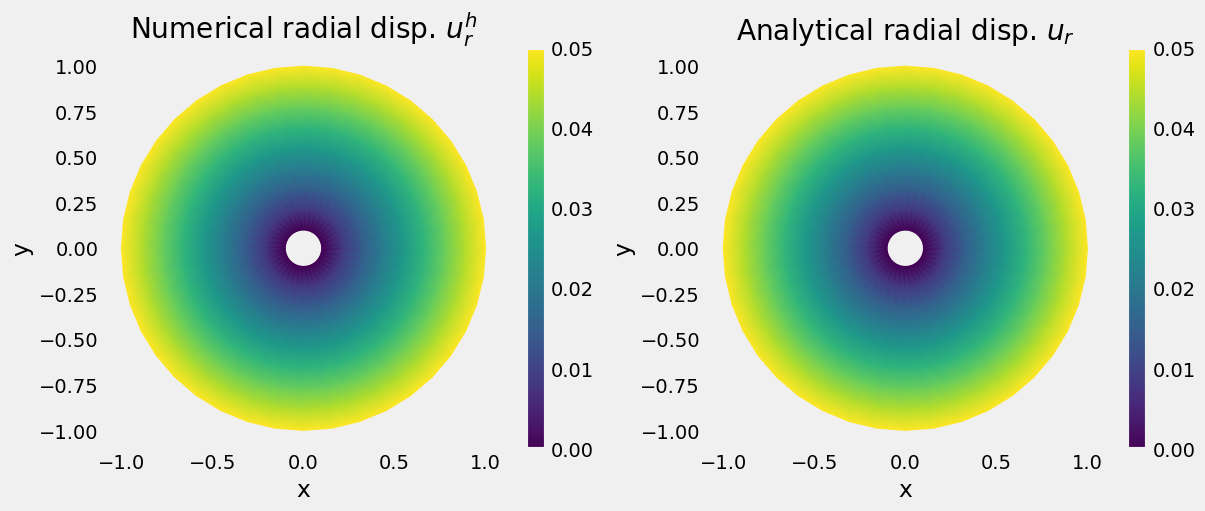

In [16]:
def q4_to_triangles(Connectivity):
    """
    Split each Q4 into two triangles for plotting.
    Connectivity is 1-based; we return 0-based triangle indices.
    """
    conn0 = Connectivity.astype(int) - 1
    Nele = conn0.shape[0]
    tris = np.zeros((2 * Nele, 3), dtype=int)
    for e in range(Nele):
        n1, n2, n3, n4 = conn0[e, :]
        tris[2*e,   :] = [n1, n2, n3]
        tris[2*e+1, :] = [n1, n3, n4]
    return tris

# Node coordinates
x = Coord[:, 0]
y = Coord[:, 1]
r = np.sqrt(x**2 + y**2)

# FE radial displacement u_r^h = u · e_r
ux = U[:, 0]
uy = U[:, 1]
ur_FE = (ux * x + uy * y) / r

# Exact radial displacement at the nodes
ur_exact = A * r + B / r   # uses A, B defined earlier

# Build triangulation
triangles = q4_to_triangles(Connectivity)
triang = mtri.Triangulation(x, y, triangles)

plt.style.use("fivethirtyeight")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Numerical
cf0 = axes[0].tripcolor(triang, ur_FE, shading="gouraud")
axes[0].set_aspect("equal")
axes[0].set_title(r"Numerical radial disp. $u_r^h$")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
fig.colorbar(cf0, ax=axes[0])

# Analytical
cf1 = axes[1].tripcolor(triang, ur_exact, shading="gouraud")
axes[1].set_aspect("equal")
axes[1].set_title(r"Analytical radial disp. $u_r$")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
fig.colorbar(cf1, ax=axes[1])

#fig.tight_layout()
img_path = IMG_DIR / "modified_lame_problem_analytical_numerical_solutions.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")
print(f"Saved plots to {img_path}")

plt.show()


In [17]:
Nr_list = [2, 4, 8, 10, 20, 30, 50]
Ntheta_per_radial = 8   # for example: Nθ = 8*Nr

h_list = []
L2_errors = []
H1_errors = []

for Nr in Nr_list:
    Ntheta = Ntheta_per_radial * Nr

    print(f"\n===== Mesh: Nr = {Nr}, Ntheta = {Ntheta} =====")
    Coord, Connectivity, Constraints = generate_Q4_thick_cylinder_mesh(
        ri=ri, ro=ro, Nr=Nr, Ntheta=Ntheta, u0=u0
    )

    U = Driver_LE(
        Connectivity,
        Constraints,
        Coord,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q4",
        load_type=load_type,
        NCons=Constraints.shape[0],
        Nele=Connectivity.shape[0],
        NGPTS=2,
    )

    # Characteristic mesh size h ~ min element edge length
    # (simple estimate using nearest radial spacing)
    dr = (ro - ri) / Nr
    dtheta = 2.0 * np.pi / Ntheta
    h = min(dr, ro * dtheta)
    h_list.append(h)

    # Error computation (vector-valued case)
    err_L2, err_H1 = Calculate_Error(
        Connectivity,
        Coord,
        EleType="Q4",
        NGPTS=2,
        U=U,
        get_exact_solution=exact_solution_thick_cylinder,
        verbose=True,
    )

    L2_errors.append(err_L2)
    H1_errors.append(err_H1)



===== Mesh: Nr = 2, Ntheta = 16 =====
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
       Error Metrics Report
       dim=2, nnode=4, Nele=32, NGPTS=2, ngauss=4, dofs_per_node=2
       L2_error           = 9.793555e-04
       H1_error_seminorm  = 7.453789e-03

===== Mesh: Nr = 4, Ntheta = 32 =====
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post

L2 slope  ≈ 1.70
H1 slope  ≈ 0.76
Saved thick-cylinder Q4 h-refinement plot to DataFiles_LE\img\thick_cylinder_Q4_h_refinement.png


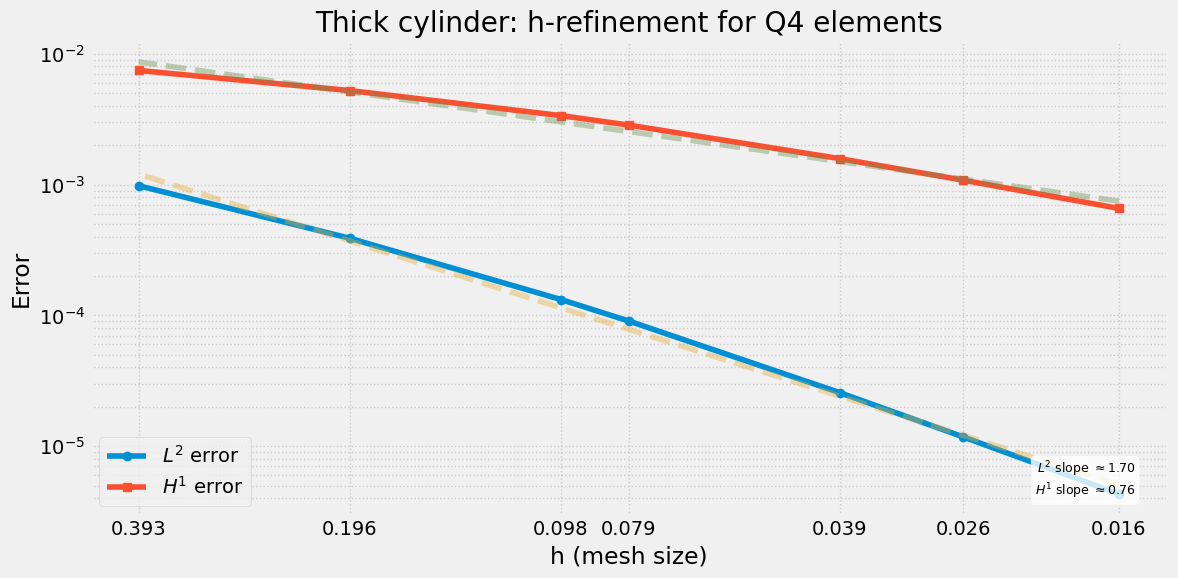

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

h_arr  = np.array(h_list)
L2_arr = np.array(L2_errors)
H1_arr = np.array(H1_errors)

# --- slopes in log10-log10 space ---
logh  = np.log10(h_arr)
logL2 = np.log10(L2_arr)
logH1 = np.log10(H1_arr)

slope_L2, intercept_L2 = np.polyfit(logh, logL2, 1)
slope_H1, intercept_H1 = np.polyfit(logh, logH1, 1)

print(f"L2 slope  ≈ {slope_L2:.2f}")
print(f"H1 slope  ≈ {slope_H1:.2f}")

plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(figsize=(12, 6))

# --- main curves ---
ax.loglog(h_arr, L2_arr, "o-", label=r"$L^2$ error")
ax.loglog(h_arr, H1_arr, "s-", label=r"$H^1$ error")

# fitted lines (optional)
h_fit = np.linspace(h_arr.min(), h_arr.max(), 100)
L2_fit = 10**intercept_L2 * h_fit**slope_L2
H1_fit = 10**intercept_H1 * h_fit**slope_H1
ax.loglog(h_fit, L2_fit, "--", alpha=0.4)
ax.loglog(h_fit, H1_fit, "--", alpha=0.4)

# --- clean x-axis: fixed locations & simple labels ---
ax.xaxis.set_major_locator(mticker.FixedLocator(h_arr))
ax.xaxis.set_minor_locator(mticker.NullLocator())   # no minor ticks

def _fmt_h(val, pos):
    # only label our actual h values; others stay blank
    if val in h_arr:
        return f"{val:.3f}"   # or "{val:.2e}" for scientific
    return ""

ax.xaxis.set_major_formatter(mticker.FuncFormatter(_fmt_h))

# (optional) keep finer meshes to the right:
ax.invert_xaxis()

ax.set_xlabel("h (mesh size)")
ax.set_ylabel("Error")
ax.set_title("Thick cylinder: h-refinement for Q4 elements")
ax.grid(True, which="both", ls=":")

ax.legend(loc="lower left")

# slope text box
textstr = "\n".join((
    rf"$L^2$ slope $\approx {slope_L2:.2f}$",
    rf"$H^1$ slope $\approx {slope_H1:.2f}$",
))
ax.text(
    0.97, 0.03, textstr,
    transform=ax.transAxes,
    fontsize=9,
    ha="right", va="bottom",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)


plt.tight_layout()

img_path = IMG_DIR / "thick_cylinder_Q4_h_refinement.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")

print(f"Saved thick-cylinder Q4 h-refinement plot to {img_path}")
plt.show()


### Strain Energy

In [19]:
def compute_total_strain_energy(
    Coord,
    Connectivity,
    U,
    medium_set,
    EleType="Q4",
    NGPTS=2,
):
    """
    Total strain energy:
        E = 1/2 ∫_Ω σ : ε dΩ
    computed by Gauss quadrature on each element using your FEM framework.
    """

    dim = Coord.shape[1]   # 2 for this problem

    # Gauss points / weights in reference element
    r, w = GaussPoints(dim, EleType, NGPTS)
    ref_pts = np.asarray(r, dtype=float)
    if ref_pts.ndim == 1:
        ref_pts = ref_pts[:, None]
    weights = np.asarray(w, dtype=float).reshape(-1)

    Nele, NodesPerEle = Connectivity.shape
    total_E = 0.0

    for e in range(Nele):
        ele_nodes = Connectivity[e, :].astype(int) - 1   # 1-based → 0-based
        xCap = Coord[ele_nodes, :]                      # (NodesPerEle, 2)
        uCap = U[ele_nodes, :]                          # (NodesPerEle, 2)
        xCap_T = xCap.T                                 # (2, NodesPerEle)

        for g, zeta in enumerate(ref_pts):
            N, DN = ShapeFunctions(EleType, zeta)

            # Geometry
            J = xCap_T @ DN               # Jacobian ∂x/∂ζ
            detJ = np.linalg.det(J)
            invJ = np.linalg.inv(J)
            Bgrad = DN @ invJ             # ∂N_i/∂x_k

            # Gauss-point coordinate (not actually used by Get_Elastic_Moduli now)
            x = xCap_T @ N                # shape (2,) or (2,1)
            lam, mu = Get_Elastic_Moduli(medium_set, x)

            # Displacement gradient: grad_u[k,j] = ∂u_j/∂x_k
            grad_u = Bgrad.T @ uCap       # (2,2)

            # Small-strain tensor ε = 1/2(∇u + ∇u^T)
            eps = 0.5 * (grad_u + grad_u.T)

            tr_eps  = np.trace(eps)
            eps_eps = np.sum(eps * eps)   # ε:ε

            # Energy density w = 1/2(λ tr(ε)^2 + 2 μ ε:ε)
            w_density = 0.5 * (lam * tr_eps**2 + 2.0 * mu * eps_eps)

            total_E += weights[g] * detJ * w_density

    return float(total_E)


In [20]:
# ri, ro = 0.1, 1.0
# u0 = 0.05
# E = 1.0e5
# nu = 0.3

# E_exact_total = (
#     np.pi * E * u0**2
#     * (-nu*ri**2 + nu*ro**2 + ri**2 + ro**2)
#     / (nu**2*ri**2 - nu**2*ro**2 - ri**2 + ro**2)
# )

# print(f"Analytical total strain energy = {E_exact_total:.6e}")


In [21]:
# Material (plane stress, constant)
lam = E * nu / (1.0 - nu**2)
mu  = E / (2.0 * (1.0 + nu))
medium_set = {"type": "Lame_params", "lambda": lam, "mu": mu}

# No body force; use rhob = 0 so Get_Rhob returns zero
load_type = {"case": "2D_gravity", "rhob": 0.0}

Nr_list = [4, 8, 16, 32]   # radial refinements
Ntheta  = 40               # circumferential elements (fixed)

h_list      = []
L2_errors   = []
H1_errors   = []
energy_list = []

for Nr in Nr_list:
    # --- mesh (plug in your own mesh generator here) ---
    Coord, Connectivity, Constraints = generate_Q4_thick_cylinder_mesh(
        Nr=Nr, Ntheta=Ntheta, ri=ri, ro=ro
    )

    h = (ro - ri) / Nr      # characteristic mesh size
    h_list.append(h)

    Nele = Connectivity.shape[0]
    NCons = Constraints.shape[0]

    # --- solve with your Driver_LE (note: NO NumNodes, NO OutFile) ---
    U = Driver_LE(
        Connectivity,
        Constraints,
        Coord,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q4",
        load_type=load_type,
        NCons=NCons,
        Nele=Nele,
        NGPTS=2,
    )

    # --- errors (3.5) ---
    err_L2, err_H1 = Calculate_Error(
        Connectivity,
        Coord,
        EleType="Q4",
        NGPTS=2,
        U=U,
        get_exact_solution=exact_solution_thick_cylinder,
        verbose=False,
    )
    L2_errors.append(err_L2)
    H1_errors.append(err_H1)

    # --- total strain energy (3.4) ---
    E_tot = compute_total_strain_energy(
        Coord,
        Connectivity,
        U,
        medium_set,
        EleType="Q4",
        NGPTS=2,
    )
    energy_list.append(E_tot)

    print(
        f"Nr = {Nr:2d}, h = {h:.4e}, "
        f"E_strain = {E_tot:.6e},  L2 = {err_L2:.3e},  H1 = {err_H1:.3e}"
    )


       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Nr =  4, h = 2.2500e-01, E_strain = 1.136422e+03,  L2 = 3.931e-04,  H1 = 5.200e-03
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
Nr =  8, h = 1.1250e-01, E_strain = 1.135420e+03,  L2 = 1.278e-04,  H1 = 3.42

Saved strain-energy plot to DataFiles_LE\img\thick_cylinder_total_strain_energy_vs_h.png


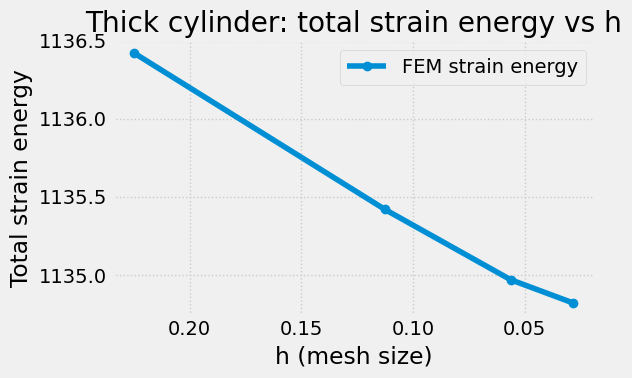

In [22]:
h_arr = np.array(h_list)
E_arr = np.array(energy_list)

plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(figsize=(6.5, 4))

# Only FEM strain energy
ax.plot(h_arr, E_arr, "o-", label="FEM strain energy")

ax.invert_xaxis()
ax.set_xlabel("h (mesh size)")
ax.set_ylabel("Total strain energy")
ax.set_title("Thick cylinder: total strain energy vs h")
ax.grid(True, ls=":")
ax.legend(loc="best")

fig.tight_layout()
img_path = IMG_DIR / "thick_cylinder_total_strain_energy_vs_h.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")
print(f"Saved strain-energy plot to {img_path}")
plt.show()


L2 slope ≈ 2.03
H1 slope ≈ 0.68
Saved error-vs-h plot to DataFiles_LE\img\thick_cylinder_Q4_error_vs_h.png


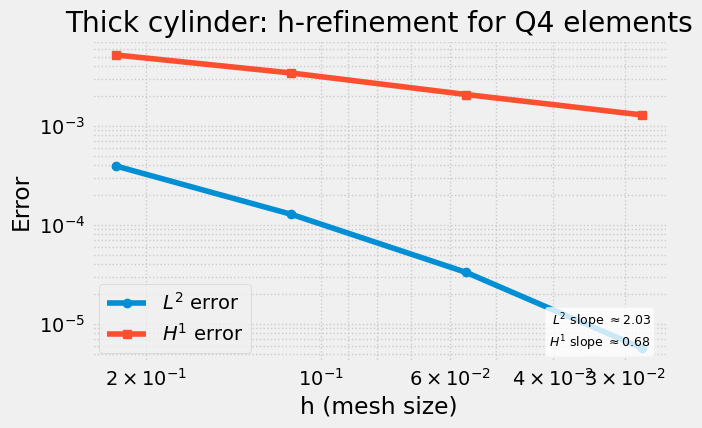

In [23]:
h_arr  = np.array(h_list)
L2_arr = np.array(L2_errors)
H1_arr = np.array(H1_errors)

logh  = np.log10(h_arr)
logL2 = np.log10(L2_arr)
logH1 = np.log10(H1_arr)

slope_L2, _ = np.polyfit(logh, logL2, 1)
slope_H1, _ = np.polyfit(logh, logH1, 1)

print(f"L2 slope ≈ {slope_L2:.2f}")
print(f"H1 slope ≈ {slope_H1:.2f}")

fig, ax = plt.subplots(figsize=(7, 4.5))

ax.loglog(h_arr, L2_arr, "o-", label=r"$L^2$ error")
ax.loglog(h_arr, H1_arr, "s-", label=r"$H^1$ error")

ax.invert_xaxis()
ax.set_xlabel("h (mesh size)")
ax.set_ylabel("Error")
ax.set_title("Thick cylinder: h-refinement for Q4 elements")
ax.grid(True, which="both", ls=":")
ax.legend(loc="lower left")

textstr = "\n".join((
    rf"$L^2$ slope $\approx {slope_L2:.2f}$",
    rf"$H^1$ slope $\approx {slope_H1:.2f}$",
))
ax.text(
    0.97, 0.03, textstr,
    transform=ax.transAxes,
    fontsize=9,
    ha="right", va="bottom",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

fig.tight_layout()
img_path = IMG_DIR / "thick_cylinder_Q4_error_vs_h.png"
fig.savefig(img_path, dpi=300, bbox_inches="tight")
print(f"Saved error-vs-h plot to {img_path}")
plt.show()


### 4. Cook's Problem

----------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Cook’s Membrane: Geometry, Mesh, Constraints, and Loads
----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
import numpy as np


# =====================================================================
# Cook’s Membrane Geometry
# =====================================================================
def get_cooks_membrane_corners():
    """
    Returns the corner coordinates of Cook's membrane.

    Geometry (as per assignment figure):
        D = (0,  0)   bottom-left (clamped)
        C = (0, 44)   top-left    (clamped)
        B = (48,44)   bottom-right
        A = (48,60)   top-right   (loaded edge)

    Returns
    -------
    tuple of np.ndarray
        (A, B, C, D), each array has shape (2,).
    """
    D = np.array([0.0,  0.0])
    C = np.array([0.0, 44.0])
    B = np.array([48.0,44.0])
    A = np.array([48.0,60.0])
    return A, B, C, D


# =====================================================================
# Structured Q4 Mesh Generator for Cook’s Membrane
# =====================================================================
def generate_cooks_membrane_q4_mesh(Nx: int, Ny: int):
    """
    Generates a structured Q4 mesh for Cook's membrane using a bilinear
    isoparametric mapping from the reference square [-1,1]x[-1,1].

    Parameters
    ----------
    Nx : int
        Number of elements in the horizontal direction.
    Ny : int
        Number of elements in the vertical direction.

    Returns
    -------
    Coord : np.ndarray
        Nodal coordinates (NumNodes x 2).
    Connectivity : np.ndarray
        Element connectivity (Nele x 4), 1-based indexing.
    """
    A, B, C, D = get_cooks_membrane_corners()

    # Reference-to-physical node ordering for Q4:
    # (-1,-1) -> D
    # ( 1,-1) -> B
    # ( 1, 1) -> A
    # (-1, 1) -> C
    P = np.vstack([D, B, A, C])

    xi  = np.linspace(-1.0, 1.0, Nx + 1)
    eta = np.linspace(-1.0, 1.0, Ny + 1)

    # --------------------------------------------------
    # Generate nodal coordinates
    # --------------------------------------------------
    Coord = []
    for j in range(Ny + 1):
        for i in range(Nx + 1):
            N1 = 0.25 * (1 - xi[i]) * (1 - eta[j])
            N2 = 0.25 * (1 + xi[i]) * (1 - eta[j])
            N3 = 0.25 * (1 + xi[i]) * (1 + eta[j])
            N4 = 0.25 * (1 - xi[i]) * (1 + eta[j])

            x = N1 * P[0] + N2 * P[1] + N3 * P[2] + N4 * P[3]
            Coord.append(x)

    Coord = np.array(Coord)

    # --------------------------------------------------
    # Connectivity (standard structured Q4)
    # --------------------------------------------------
    Connectivity = []
    for j in range(Ny):
        for i in range(Nx):
            n1 = j * (Nx + 1) + i + 1
            n2 = n1 + 1
            n3 = n1 + Nx + 2
            n4 = n1 + Nx + 1
            Connectivity.append([n1, n2, n3, n4])

    Connectivity = np.array(Connectivity, dtype=int)

    return Coord, Connectivity


# =====================================================================
# Cook’s Membrane Essential Boundary Conditions (Clamped Edge)
# =====================================================================
def build_cooks_membrane_dirichlet_bcs(Coord: np.ndarray, tol: float = 1e-10):
    """
    Builds Dirichlet boundary conditions for Cook's membrane.

    Clamped boundary:
        x = 0  =>  Ux = 0, Uy = 0

    Parameters
    ----------
    Coord : np.ndarray
        Nodal coordinates (NumNodes x 2).
    tol : float
        Tolerance for identifying the left boundary.

    Returns
    -------
    Constraints : np.ndarray
        Dirichlet BC array [node, dof, value].
    """
    left_nodes = np.where(np.abs(Coord[:, 0]) < tol)[0]

    Constraints = []
    for node in left_nodes:
        Constraints.append([node + 1, 1, 0.0])  # Ux = 0
        Constraints.append([node + 1, 2, 0.0])  # Uy = 0

    return np.array(Constraints, dtype=float)


# =====================================================================
# Cook’s Membrane Edge Traction -> Equivalent Nodal Point Loads
# =====================================================================
def build_cooks_membrane_edge_traction_as_point_loads(
    Coord: np.ndarray,
    traction_V: float = 100.0,
    x_loaded: float = 48.0,
    y_min: float = 44.0,
    y_max: float = 60.0,
    tol: float = 1e-10,
):
    """
    Converts a uniform vertical traction on the loaded edge into equivalent nodal loads.

    Loaded edge:
        x = x_loaded,  y in [y_min, y_max]

    The traction is converted to nodal point loads by distributing the total force
    across edge segments using a trapezoidal rule (end nodes get half weight).

    Parameters
    ----------
    Coord : np.ndarray
        Nodal coordinates.
    traction_V : float
        Traction magnitude (force/length).
    x_loaded : float
        x-location of loaded edge.
    y_min, y_max : float
        Vertical span of loaded edge.
    tol : float
        Tolerance for identifying nodes on the loaded edge.

    Returns
    -------
    point_load : np.ndarray
        Array [node, dof, value] where dof=2 is the vertical direction.
    """
    L = y_max - y_min
    F_total = traction_V * L

    # Nodes on x = x_loaded
    right_nodes = np.where(np.abs(Coord[:, 0] - x_loaded) < tol)[0]

    # Restrict to y in [y_min, y_max]
    yvals = Coord[right_nodes, 1]
    mask = (yvals >= y_min) & (yvals <= y_max)
    load_nodes = right_nodes[mask]

    # Sort bottom -> top
    load_nodes = load_nodes[np.argsort(Coord[load_nodes, 1])]

    n = len(load_nodes)
    if n < 2:
        raise RuntimeError("Insufficient nodes on the loaded edge to distribute traction.")

    Pint = F_total / (n - 1)

    point_load = []
    for k, node in enumerate(load_nodes):
        if k == 0 or k == n - 1:
            val = 0.5 * Pint
        else:
            val = Pint

        point_load.append([node + 1, 2, val])  # DOF=2 (vertical)

    return np.array(point_load, dtype=float)


### Vertical tip displacement at A for various (hierarchical) meshes

Cook’s Membrane (Problem 4.1) — Q4 FEM Tip Displacement Convergence
Material: E = 100, nu = 0.4999   |   EleType = Q4   |   NGPTS = 2
Tip point: A = (48, 60)   |   Load: traction on AB -> equivalent nodal point loads
Mesh (Nx=Ny) |   #Nodes |   #Elems |         u_y(A)
------------------------------------------------------------------------------
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
           2 |        9 |        4 |   8.135942e+01
       Quasi-static Linear Elasticity Simulation Status Report    

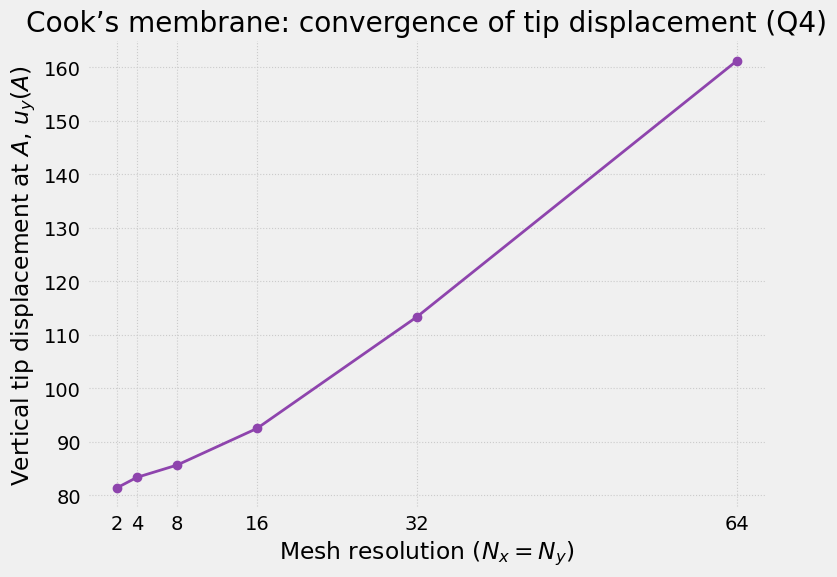

In [25]:

# =====================================================================
# Cook’s Membrane (Problem 4.1) — Solver (No plotting inside)
# =====================================================================
def run_cooks_problem_4_1_tip_displacement(
    mesh_levels=(2, 4, 8, 16, 32, 64),
    E=100.0,
    nu=0.4999,
    EleType="Q4",
    NGPTS=2,
    verbose=True,
):
    """
    Solves Cook's membrane using a hierarchy of structured Q4 meshes and returns
    the vertical displacement at point A = (48, 60).

    Notes
    -----
    - Uses:
        * generate_cooks_membrane_q4_mesh
        * build_cooks_membrane_dirichlet_bcs
        * build_cooks_membrane_edge_traction_as_point_loads
    - Applies edge traction via nodal point loads using Driver_LE(point_load=...).

    Parameters
    ----------
    mesh_levels : tuple[int]
        Hierarchical mesh sizes (Nx = Ny), from coarse to fine.
    E, nu : float
        Material properties.
    EleType : str
        Element type (default: "Q4").
    NGPTS : int
        Gauss points per direction (default: 2).
    verbose : bool
        If True, prints a concise solver summary table.

    Returns
    -------
    results : dict
        Dictionary containing mesh sizes, tip displacements, and mesh statistics.
    """
    # ------------------------------------------------------------
    # Material (Lamé parameters)
    # ------------------------------------------------------------
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    mu  = E / (2.0 * (1.0 + nu))
    medium_set = {"type": "Lame_params", "lambda": lam, "mu": mu}

    # ------------------------------------------------------------
    # Load type (no body force for Cook’s problem)
    # ------------------------------------------------------------
    load_type = {"case": "2D_gravity", "rhob": 0.0}

    # ------------------------------------------------------------
    # Target point A
    # ------------------------------------------------------------
    A, _, _, _ = get_cooks_membrane_corners()

    mesh_sizes = list(mesh_levels)
    uy_A_list = []
    num_nodes_list = []
    num_elem_list = []

    if verbose:
        header = "=" * 78
        print(header)
        print("Cook’s Membrane (Problem 4.1) — Q4 FEM Tip Displacement Convergence")
        print(f"Material: E = {E:.3g}, nu = {nu:.4f}   |   EleType = {EleType}   |   NGPTS = {NGPTS}")
        print("Tip point: A = (48, 60)   |   Load: traction on AB -> equivalent nodal point loads")
        print(header)
        print(f"{'Mesh (Nx=Ny)':>12} | {'#Nodes':>8} | {'#Elems':>8} | {'u_y(A)':>14}")
        print("-" * 78)

    for Nx in mesh_sizes:
        Ny = Nx

        # ---- Mesh + BCs + Loads ----
        Coord, Connectivity = generate_cooks_membrane_q4_mesh(Nx, Ny)
        Constraints = build_cooks_membrane_dirichlet_bcs(Coord)
        point_load = build_cooks_membrane_edge_traction_as_point_loads(Coord)

        NumNodes = Coord.shape[0]
        Nele = Connectivity.shape[0]

        # ---- Solve ----
        U = Driver_LE(
            Connectivity=Connectivity,
            Constraints=Constraints,
            Coord=Coord,
            medium_set=medium_set,
            dim=2,
            dofs_per_node=2,
            EleType=EleType,
            load_type=load_type,
            NCons=Constraints.shape[0],
            Nele=Nele,
            NGPTS=NGPTS,
            point_load=point_load,
        )

        # ---- Tip displacement at A (closest node) ----
        nodeA = np.argmin(np.linalg.norm(Coord - A, axis=1))
        uyA = U[nodeA, 1]

        uy_A_list.append(uyA)
        num_nodes_list.append(NumNodes)
        num_elem_list.append(Nele)

        if verbose:
            print(f"{Nx:12d} | {NumNodes:8d} | {Nele:8d} | {uyA:14.6e}")

    if verbose:
        print("-" * 78)
        print(f"Finest mesh: Nx=Ny={mesh_sizes[-1]}  ->  u_y(A) = {uy_A_list[-1]:.6e}")
        print("=" * 78)

    return {
        "mesh_sizes": mesh_sizes,
        "uy_A": uy_A_list,
        "num_nodes": num_nodes_list,
        "num_elems": num_elem_list,
        "E": E,
        "nu": nu,
        "EleType": EleType,
        "NGPTS": NGPTS,
    }


results = run_cooks_problem_4_1_tip_displacement(mesh_levels=(2,4,8,16,32,64), E=100, nu=0.4999)

Nx_list = results["mesh_sizes"]
uyA = results["uy_A"]

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(Nx_list, uyA, marker="o", linewidth=2.0, color='#8E44AD', markersize=6.0)
ax.set_xlabel(r"Mesh resolution ($N_x = N_y$)")
ax.set_ylabel(r"Vertical tip displacement at $A$, $u_y(A)$")
ax.set_title(r"Cook’s membrane: convergence of tip displacement (Q4)")
ax.set_xticks(Nx_list)
ax.grid(True, linestyle=":", linewidth=0.8)

fig.tight_layout()
fig.savefig("Cook_4_1_tip_displacement_convergence.pdf", dpi=300, bbox_inches="tight")
plt.show()

### Stress recovery (2D, Q4) for Cook's problem: plane strain, nodal avg


In [26]:
def run_cook_4_2():

    plt.style.use("fivethirtyeight")

    # ==========================================================
    # (Cook 4.2) Material
    # ==========================================================
    #E  = 100000.0 
    E = 100.0
    nu = 0.4999

    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    mu  = E / (2.0 * (1.0 + nu))

    medium_set = {"type": "Lame_params", "lambda": lam, "mu": mu}

    # ==========================================================
    # (Cook 4.2) Mesh + BCs + Edge traction -> nodal point loads
    # ==========================================================
    Nx, Ny = 64, 64
    Coord, Connectivity = generate_cooks_membrane_q4_mesh(Nx, Ny)
    Constraints = build_cooks_membrane_dirichlet_bcs(Coord)

    point_load = build_cooks_membrane_edge_traction_as_point_loads(
        Coord=Coord,
        traction_V=100.0,
        x_loaded=48.0,
        y_min=44.0,
        y_max=60.0,
        tol=1e-10,
    )

    load_type = {"case": "2D_gravity", "rhob": 0.0}

    # ==========================================================
    # (Cook 4.2) Solve displacements with your Driver_LE
    # ==========================================================
    U = Driver_LE(
        Connectivity=Connectivity,
        Constraints=Constraints,
        Coord=Coord,
        medium_set=medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q4",
        load_type=load_type,
        NCons=Constraints.shape[0],
        Nele=Connectivity.shape[0],
        NGPTS=2,
        point_load=point_load,
    )

    # ==========================================================
    # (Cook 4.2) Nodal averaging of tr[T] from element corner stresses
    # ==========================================================
    NumNodes = Coord.shape[0]
    Nele = Connectivity.shape[0]

    trT_accum = np.zeros(NumNodes, dtype=float)
    count_accum = np.zeros(NumNodes, dtype=float)

    # Q4 corner order consistent with your Q4 definition:
    # (-1,-1),(1,-1),(1,1),(-1,1)
    ref_corners = np.array(
        [[-1.0, -1.0],
         [ 1.0, -1.0],
         [ 1.0,  1.0],
         [-1.0,  1.0]],
        dtype=float
    )

    for e in range(Nele):
        nodes = Connectivity[e, :].astype(int) - 1   # 0-based global ids
        xCap  = Coord[nodes, :]                      # (4,2)
        UCap  = U[nodes, :]                          # (4,2)

        for a_local, (xi, eta) in enumerate(ref_corners):
            # Your Q4 shape function routine; DN is (4,2) wrt (xi,eta)

            z = np.array([xi, eta], dtype=float)
            N, DN = ShapeFunctions("Q4", z)      # DN: (4,2) wrt (xi,eta)

            # Jacobian and dN/dx
            J = xCap.T @ DN
            detJ = np.linalg.det(J)
            if detJ <= 0.0:
                raise ValueError(
                    f"det(J) <= 0 in element {e+1}. "
                    f"detJ = {detJ:.3e}. Check node ordering / mapping."
                )

            invJ = np.linalg.inv(J)
            dNdx = DN @ invJ                          # (4,2)

            # ------------------------------------------------------
            # Dimension-aware displacement gradient:
            # grad(u) = UCap^T * dNdx   (2x2)
            # ------------------------------------------------------
            grad_u = UCap.T @ dNdx

            # Small strain tensor
            eps = 0.5 * (grad_u + grad_u.T)
            eps_xx = eps[0, 0]
            eps_yy = eps[1, 1]

            # Plane strain stresses
            sigma_xx = (lam + 2.0 * mu) * eps_xx + lam * eps_yy
            sigma_yy = lam * eps_xx + (lam + 2.0 * mu) * eps_yy
            sigma_zz = lam * (eps_xx + eps_yy)

            trT = sigma_xx + sigma_yy + sigma_zz

            gid = nodes[a_local]
            trT_accum[gid] += trT
            count_accum[gid] += 1.0

    trT_nodes = trT_accum / np.maximum(count_accum, 1.0)

    # ==========================================================
    # (Cook 4.2) Extract tr[T] along BC: x = 24, y in [22,52]
    # ==========================================================
    tol = 1e-6
    x = Coord[:, 0]
    y = Coord[:, 1]

    mask = (np.abs(x - 24.0) < tol) & (y >= 22.0) & (y <= 52.0)
    bc_nodes = np.where(mask)[0]

    if bc_nodes.size < 2:
        raise RuntimeError(
            "Not enough nodes detected on BC (x=24, y in [22,52]). "
            "Increase mesh resolution or relax tolerance."
        )

    order = np.argsort(y[bc_nodes])
    y_vals = y[bc_nodes][order]
    trT_vals = trT_nodes[bc_nodes][order]

    # ==========================================================
    # (Cook 4.2) Plot
    # ==========================================================
    fig, ax = plt.subplots(figsize=(7.2, 4.6))

    ax.plot(y_vals, trT_vals, "o-", linewidth=2, color= "#8E44AD",markersize=5)

    ax.set_xlabel(r"$y$ along $BC$")
    ax.set_ylabel(r"$\mathrm{tr}[\mathbf{T}]$")
    ax.set_title(r"Cook's Problem: $\mathrm{tr}[\mathbf{T}]$ along $BC$ (nodal averaging)")
    ax.grid(True, ls=":", alpha=0.7)

    fig.tight_layout()
    outname = "Cook_4_2_trT_along_BC.pdf"
    fig.savefig(outname, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"\nSaved: {outname}")

    return Coord, y_vals, trT_vals


       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     


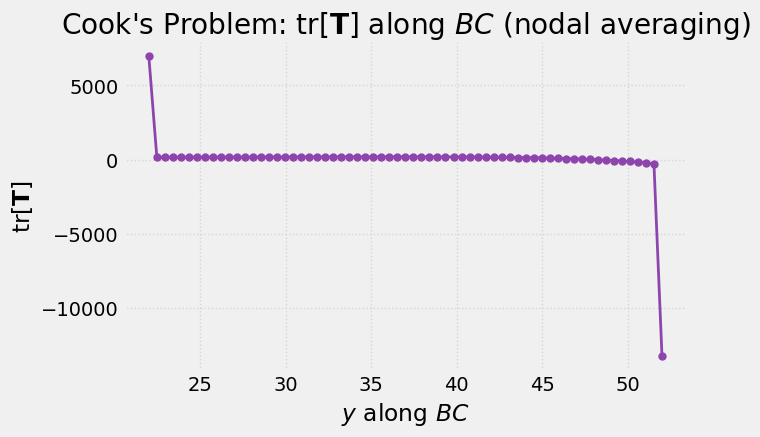


Saved: Cook_4_2_trT_along_BC.pdf


In [27]:
if __name__ == "__main__": 
    run_cook_4_2()

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     


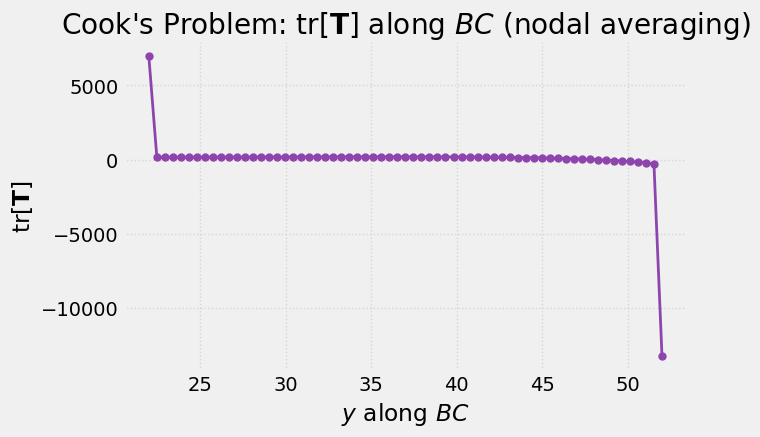


Saved: Cook_4_2_trT_along_BC.pdf
First point (y,trT): 22.0 6963.150336034982
Last  point (y,trT): 52.0 -13210.071455146212


In [28]:
Coord, y_vals, trT_vals = run_cook_4_2()

y_plot   = y_vals[1:-1]
trT_plot = trT_vals[1:-1]

print("First point (y,trT):", y_vals[0], trT_vals[0])
print("Last  point (y,trT):", y_vals[-1], trT_vals[-1])



Saved: Cook_4_2_trT_along_BC_exclude_boundary.pdf


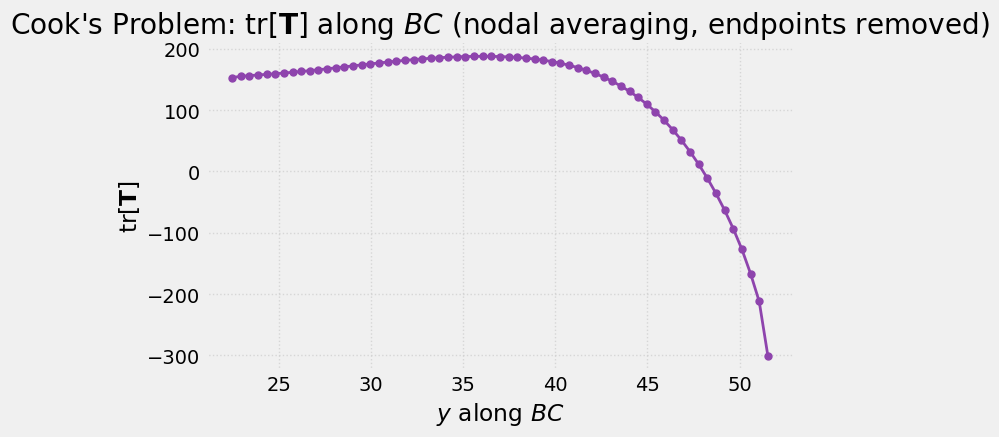

In [29]:
# after y_vals, trT_vals are computed
y_plot   = y_vals[1:-1]
trT_plot = trT_vals[1:-1]

fig, ax = plt.subplots(figsize=(7.2, 4.6))
ax.plot(y_plot, trT_plot, "o-", color="#8E44AD", linewidth=2, markersize=5)
ax.set_xlabel(r"$y$ along $BC$")
ax.set_ylabel(r"$\mathrm{tr}[\mathbf{T}]$")
ax.set_title(r"Cook's Problem: $\mathrm{tr}[\mathbf{T}]$ along $BC$ (nodal averaging, endpoints removed)")
ax.grid(True, ls=":", alpha=0.7)
fig.tight_layout()
outname = "Cook_4_2_trT_along_BC_exclude_boundary.pdf"
fig.savefig(outname, dpi=300, bbox_inches="tight")
print(f"\nSaved: {outname}")
plt.show()


In [30]:
print(trT_plot.min(), trT_plot.max())

-300.2168414385401 187.59904212120352


Cook (4.3): Tip displacement u_y(A) vs Poisson's ratio (finest mesh)
Mesh: Nx=Ny=64 | EleType=Q4 | NGPTS=2 | E=100.0
Tip node id (0-based) = 4224, Coord = [48. 60.]
        nu |             u_y(A)
------------------------------------------------------------------------
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
    0.0000 |   3.9009143191e+02
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Const

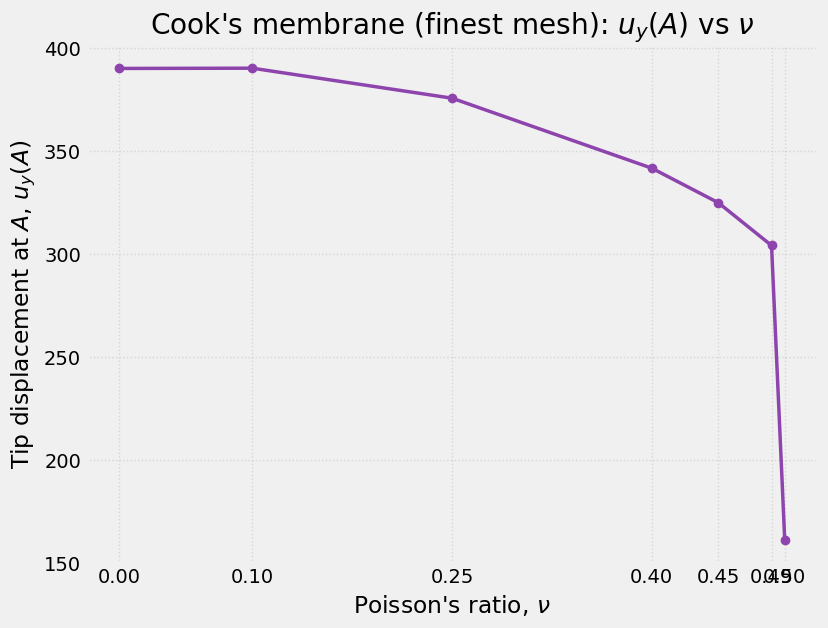


Saved: Cook_4_3_tip_displacement_vs_nu.pdf


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# Cook 4.3: Tip displacement at A vs Poisson's ratio (finest mesh)
# ==========================================================

plt.style.use("fivethirtyeight")

# ---- Finest mesh (from your hierarchy, finest = 64) ----
Nx, Ny = 64, 64
EleType = "Q4"
NGPTS = 2

# ---- Problem data (set E to 100 if following the assignment literally) ----
E = 100.0          # <-- assignment says E = 100
#E = 100000.0     # <-- if you want to keep your earlier scaling, uncomment this instead

nu_list = [0.0, 0.1, 0.25, 0.4, 0.45, 0.49, 0.4999]

# ---- Load settings (matches your traction builder defaults / figure V=100) ----
traction_V = 100.0
x_loaded = 48.0
y_load_min, y_load_max = 44.0, 60.0

# ---- Build mesh + BCs + loads once (same for all nu) ----
A, _, _, _ = get_cooks_membrane_corners()

Coord, Connectivity = generate_cooks_membrane_q4_mesh(Nx, Ny)
Constraints = build_cooks_membrane_dirichlet_bcs(Coord)

point_load = build_cooks_membrane_edge_traction_as_point_loads(
    Coord=Coord,
    traction_V=traction_V,
    x_loaded=x_loaded,
    y_min=y_load_min,
    y_max=y_load_max,
    tol=1e-10,
)

load_type = {"case": "2D_gravity", "rhob": 0.0}

# tip node = closest node to A=(48,60)
nodeA = int(np.argmin(np.linalg.norm(Coord - A, axis=1)))

# ---- Solve for each nu and collect u_y(A) ----
uyA_list = []

print("=" * 72)
print("Cook (4.3): Tip displacement u_y(A) vs Poisson's ratio (finest mesh)")
print(f"Mesh: Nx=Ny={Nx} | EleType={EleType} | NGPTS={NGPTS} | E={E}")
print(f"Tip node id (0-based) = {nodeA}, Coord = {Coord[nodeA]}")
print("=" * 72)
print(f"{'nu':>10} | {'u_y(A)':>18}")
print("-" * 72)

for nu in nu_list:
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    mu  = E / (2.0 * (1.0 + nu))
    medium_set = {"type": "Lame_params", "lambda": lam, "mu": mu}

    U = Driver_LE(
        Connectivity=Connectivity,
        Constraints=Constraints,
        Coord=Coord,
        medium_set=medium_set,
        dim=2,
        dofs_per_node=2,
        EleType=EleType,
        load_type=load_type,
        NCons=Constraints.shape[0],
        Nele=Connectivity.shape[0],
        NGPTS=NGPTS,
        point_load=point_load,
    )

    uyA = float(U[nodeA, 1])   # vertical displacement at A
    uyA_list.append(uyA)

    print(f"{nu:10.4f} | {uyA:18.10e}")

print("-" * 72)
print(f"min u_y(A) = {min(uyA_list):.6e},  max u_y(A) = {max(uyA_list):.6e}")
print("=" * 72)

# ---- Plot (your style + your default color) ----
color = "#8E44AD"

fig, ax = plt.subplots(figsize=(8.5, 6.5))
ax.plot(nu_list, uyA_list, "o-", linewidth=2.5, markersize=6, color=color)

ax.set_xlabel(r"Poisson's ratio, $\nu$")
ax.set_ylabel(r"Tip displacement at $A$, $u_y(A)$")
ax.set_title(r"Cook's membrane (finest mesh): $u_y(A)$ vs $\nu$")
ax.grid(True, linestyle=":", alpha=0.7)

ax.set_xticks(nu_list)
fig.tight_layout()

outname = "Cook_4_3_tip_displacement_vs_nu.pdf"
fig.savefig(outname, dpi=300, bbox_inches="tight")
plt.show()

print(f"\nSaved: {outname}")


In [32]:
import gmsh
print(gmsh.__version__)
gmsh.initialize(); gmsh.finalize()


4.15.0


In [36]:
import numpy as np

def generate_cooks_membrane_q4_mesh_gmsh(
    h=1.0,
    *,
    embed_BC=True,
    recombine=True,
    verbose=True,
):
    """
    Gmsh-based Q4 mesh for Cook's membrane.

    Returns
    -------
    Coord : (NumNodes, 2)
    Connectivity : (Nele, 4) 1-based, Q4 order compatible with ShapeFunctions("Q4", z)
    """
    try:
        import gmsh
    except ImportError as e:
        raise ImportError("gmsh not found. Run: python -m pip install gmsh") from e

    D = (0.0,  0.0)
    C = (0.0, 44.0)
    B = (48.0,44.0)
    A = (48.0,60.0)

    # Probe line BC: x=24, y in [22,52]
    P1 = (24.0, 22.0)
    P2 = (24.0, 52.0)

    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1 if verbose else 0)
    gmsh.model.add("cooks_membrane")

    # Geometry
    pD = gmsh.model.geo.addPoint(D[0], D[1], 0.0, h)
    pB = gmsh.model.geo.addPoint(B[0], B[1], 0.0, h)
    pA = gmsh.model.geo.addPoint(A[0], A[1], 0.0, h)
    pC = gmsh.model.geo.addPoint(C[0], C[1], 0.0, h)

    lDB = gmsh.model.geo.addLine(pD, pB)
    lBA = gmsh.model.geo.addLine(pB, pA)
    lAC = gmsh.model.geo.addLine(pA, pC)
    lCD = gmsh.model.geo.addLine(pC, pD)

    cloop = gmsh.model.geo.addCurveLoop([lDB, lBA, lAC, lCD])
    surf  = gmsh.model.geo.addPlaneSurface([cloop])

    # Embed BC line so x=24 line has actual nodes
    if embed_BC:
        p1  = gmsh.model.geo.addPoint(P1[0], P1[1], 0.0, h)
        p2  = gmsh.model.geo.addPoint(P2[0], P2[1], 0.0, h)
        lBC = gmsh.model.geo.addLine(p1, p2)
        gmsh.model.geo.synchronize()
        gmsh.model.mesh.embed(1, [lBC], 2, surf)
    else:
        gmsh.model.geo.synchronize()

    # Ask for quads
    if recombine:
        gmsh.model.mesh.setRecombine(2, surf)
        gmsh.option.setNumber("Mesh.RecombineAll", 1)

    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", h)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", h)

    gmsh.model.mesh.generate(2)

    # ---------------------------
    # Get Q4 elements (type=3)
    # ---------------------------
    elemTags, elemNodeTags = gmsh.model.mesh.getElementsByType(3)
    if elemNodeTags.size == 0:
        gmsh.finalize()
        raise RuntimeError("No Q4 elements found. Gmsh produced triangles only.")

    elemNodeTags = elemNodeTags.astype(np.int64).reshape(-1, 4)  # (Nele,4)

    # ---------------------------
    # Get all nodes (tags + coords)
    # ---------------------------
    nodeTags, nodeCoords, _ = gmsh.model.mesh.getNodes()
    nodeTags  = nodeTags.astype(np.int64)
    allCoord  = nodeCoords.reshape(-1, 3)[:, :2]  # (Nall,2)

    gmsh.finalize()

    # ---------------------------
    # CRITICAL FIX:
    # Keep only nodes used by Q4 elements and renumber
    # ---------------------------
    usedTags = np.unique(elemNodeTags.ravel())
    usedTags.sort()

    maxTag = int(nodeTags.max())
    tag2pos = np.full(maxTag + 1, -1, dtype=np.int64)
    tag2pos[nodeTags] = np.arange(nodeTags.size, dtype=np.int64)

    pos = tag2pos[usedTags]
    if np.any(pos < 0):
        bad = usedTags[pos < 0][:10]
        raise RuntimeError(f"Some used element node tags were not found in node list. Example: {bad}")

    Coord = allCoord[pos, :].astype(float)
    NumNodes = Coord.shape[0]

    tag2new = np.zeros(maxTag + 1, dtype=np.int64)
    tag2new[usedTags] = np.arange(1, NumNodes + 1, dtype=np.int64)

    Connectivity = tag2new[elemNodeTags].astype(int)

    # ---------------------------
    # Ensure positive orientation (helps detJ)
    # ---------------------------
    def signed_area_quad(xy):
        x = xy[:, 0]; y = xy[:, 1]
        return 0.5 * (
            x[0]*y[1] - y[0]*x[1] +
            x[1]*y[2] - y[1]*x[2] +
            x[2]*y[3] - y[2]*x[3] +
            x[3]*y[0] - y[3]*x[0]
        )

    for e in range(Connectivity.shape[0]):
        ids = Connectivity[e, :] - 1
        if signed_area_quad(Coord[ids, :]) < 0.0:
            # flip: [1,2,3,4] -> [1,4,3,2]
            Connectivity[e, :] = Connectivity[e, [0, 3, 2, 1]]

    return Coord, Connectivity


#### Now using GMSH to possibly get better results

In [40]:
def read_gmsh_msh22_quads(path):
    """
    Minimal Gmsh .msh v2.2 ASCII reader for:
      - Nodes
      - 4-node quadrangles (element type 3)
    Returns:
      Coord (NumNodes,2), Connectivity (Nele,4) with 1-based indexing
    """
    with open(path, "r") as f:
        lines = f.readlines()

    # --- nodes ---
    i = lines.index("$Nodes\n")
    n_nodes = int(lines[i+1].strip())
    node_tags = []
    node_xy = []
    for k in range(n_nodes):
        parts = lines[i+2+k].split()
        tag = int(parts[0])
        x, y = float(parts[1]), float(parts[2])
        node_tags.append(tag)
        node_xy.append([x, y])
    node_tags = np.array(node_tags, dtype=int)
    node_xy   = np.array(node_xy, dtype=float)

    # map gmsh tags -> contiguous 1..NumNodes
    tag2new = {tag: (idx+1) for idx, tag in enumerate(node_tags)}

    # --- elements ---
    j = lines.index("$Elements\n")
    n_elem = int(lines[j+1].strip())

    quads = []
    used = set()

    for k in range(n_elem):
        parts = lines[j+2+k].split()
        etype = int(parts[1])
        ntags = int(parts[2])
        conn  = list(map(int, parts[3+ntags:]))

        if etype == 3:  # 4-node quad
            new_conn = [tag2new[t] for t in conn]
            quads.append(new_conn)
            used.update(new_conn)

    if len(quads) == 0:
        raise RuntimeError("No 4-node quads (etype=3) found. Check your mesh/export settings.")

    Connectivity = np.array(quads, dtype=int)

    # IMPORTANT: remove any unused nodes (avoids singular K due to isolated nodes)
    used = np.array(sorted(list(used)), dtype=int)
    old_to_compact = {old: (ii+1) for ii, old in enumerate(used)}

    Coord = node_xy[used - 1, :]  # used are 1-based
    Connectivity = np.vectorize(old_to_compact.get)(Connectivity)

    return Coord, Connectivity


In [41]:
def run_cook_4_2_from_msh(msh_path="cooks_q4_split.msh"):
    plt.style.use("fivethirtyeight")

    # --- mesh from gmsh file ---
    Coord, Connectivity = read_gmsh_msh22_quads(msh_path)

    # --- material ---
    E  = 100000.0
    nu = 0.4999
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    mu  = E / (2.0 * (1.0 + nu))
    medium_set = {"type": "Lame_params", "lambda": lam, "mu": mu}
    load_type  = {"case": "2D_gravity", "rhob": 0.0}

    # --- BCs + traction -> nodal point loads (your existing functions) ---
    Constraints = build_cooks_membrane_dirichlet_bcs(Coord, tol=1e-10)
    point_load  = build_cooks_membrane_edge_traction_as_point_loads(
        Coord=Coord,
        traction_V=100.0,
        x_loaded=48.0,
        y_min=44.0,
        y_max=60.0,
        tol=1e-10,
    )

    # --- solve ---
    U = Driver_LE(
        Connectivity=Connectivity,
        Constraints=Constraints,
        Coord=Coord,
        medium_set=medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q4",
        load_type=load_type,
        NCons=Constraints.shape[0],
        Nele=Connectivity.shape[0],
        NGPTS=2,
        point_load=point_load,
    )

    return Coord, Connectivity, U


In [42]:
def compute_trT(Coord, Connectivity, U, medium_set):
    # Initialize arrays for accumulation
    NumNodes = Coord.shape[0]
    trT_accum = np.zeros(NumNodes, dtype=float)
    count_accum = np.zeros(NumNodes, dtype=float)

    # Q4 corner order consistent with your Q4 definition:
    ref_corners = np.array(
        [[-1.0, -1.0],
         [ 1.0, -1.0],
         [ 1.0,  1.0],
         [-1.0,  1.0]],
        dtype=float
    )

    for e in range(Connectivity.shape[0]):
        nodes = Connectivity[e, :].astype(int) - 1   # 0-based global ids
        xCap  = Coord[nodes, :]                      # (4,2)
        UCap  = U[nodes, :]                          # (4,2)

        for a_local, (xi, eta) in enumerate(ref_corners):
            z = np.array([xi, eta], dtype=float)
            N, DN = ShapeFunctions("Q4", z)      # DN: (4,2) wrt (xi,eta)

            # Jacobian and dN/dx
            J = xCap.T @ DN
            detJ = np.linalg.det(J)
            if detJ <= 0.0:
                raise ValueError(
                    f"det(J) <= 0 in element {e+1}. "
                    f"detJ = {detJ:.3e}. Check node ordering / mapping."
                )

            invJ = np.linalg.inv(J)
            dNdx = DN @ invJ                          # (4,2)

            # ------------------------------------------------------
            # Dimension-aware displacement gradient:
            # grad(u) = UCap^T * dNdx   (2x2)
            # ------------------------------------------------------
            grad_u = UCap.T @ dNdx

            # Small strain tensor
            eps = 0.5 * (grad_u + grad_u.T)
            eps_xx = eps[0, 0]
            eps_yy = eps[1, 1]

            # Plane strain stresses
            sigma_xx = (lam + 2.0 * mu) * eps_xx + lam * eps_yy
            sigma_yy = lam * eps_xx + (lam + 2.0 * mu) * eps_yy
            sigma_zz = lam * (eps_xx + eps_yy)

            trT = sigma_xx + sigma_yy + sigma_zz

            gid = nodes[a_local]
            trT_accum[gid] += trT
            count_accum[gid] += 1.0

    trT_nodes = trT_accum / np.maximum(count_accum, 1.0)

    return trT_nodes


In [43]:
def plot_trT(Coord, trT_nodes):
    # Extract y and trT values for BC
    x = Coord[:, 0]
    y = Coord[:, 1]

    mask = (np.abs(x - 24.0) < 1e-6) & (y >= 22.0) & (y <= 52.0)
    bc_nodes = np.where(mask)[0]

    y_vals = y[bc_nodes]
    trT_vals = trT_nodes[bc_nodes]

    # Sort values by y for proper plotting
    order = np.argsort(y_vals)
    y_vals = y_vals[order]
    trT_vals = trT_vals[order]

    # Plot the results
    plt.plot(y_vals, trT_vals, marker='o', linestyle='-', color='purple', markersize=6)
    plt.xlabel("y along BC")
    plt.ylabel("tr[T]")
    plt.title("Cook's Problem: tr[T] along BC (nodal averaging)")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()


       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     


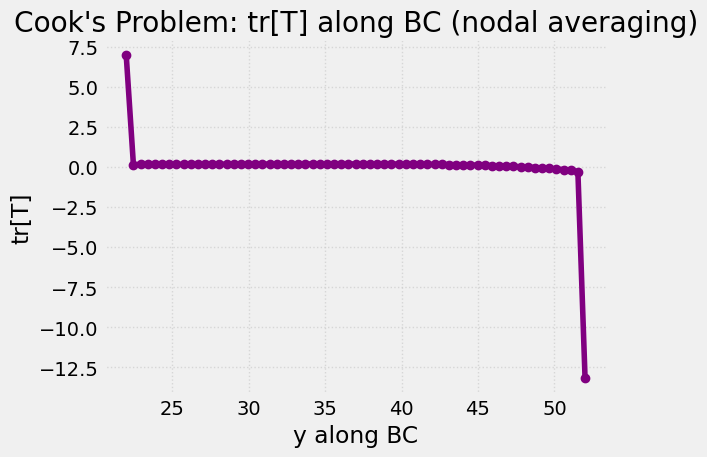

In [46]:
Coord, Connectivity, U = run_cook_4_2_from_msh(msh_path="cooks_q4_split.msh")

# Compute stress trace tr[T]
trT_nodes = compute_trT(Coord, Connectivity, U, medium_set)

# Plot the results
plot_trT(Coord, trT_nodes)


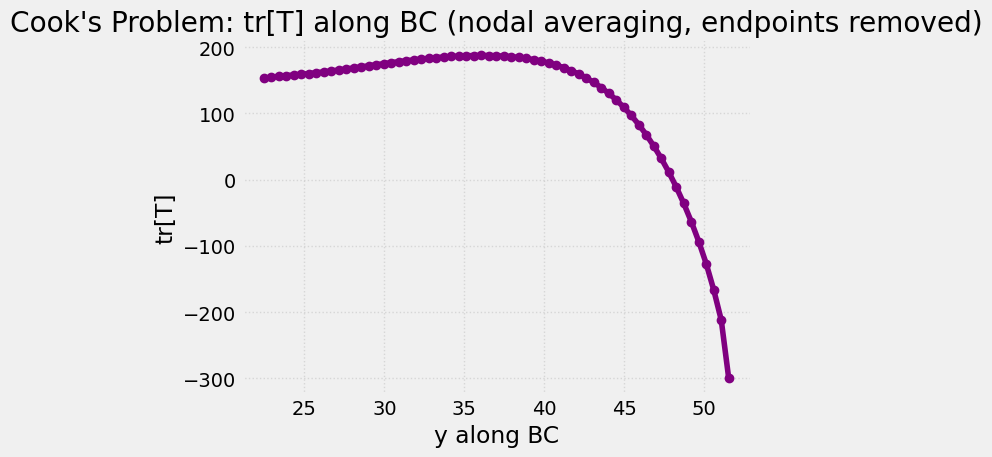

In [47]:
# Remove first and last points (boundary points)
y_vals_filtered = y_vals[1:-1]
trT_vals_filtered = trT_vals[1:-1]

# Plot the filtered data
plt.plot(y_vals_filtered, trT_vals_filtered, marker='o', linestyle='-', color='purple', markersize=6)
plt.xlabel("y along BC")
plt.ylabel("tr[T]")
plt.title("Cook's Problem: tr[T] along BC (nodal averaging, endpoints removed)")
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()


#### Design Chart - Stress Concentration Factor

       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
           Caution: point load applied on prescribed DOF (node=1, dof=1).
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
           Caution: point load applied on prescribed DOF (node=1, dof=1).
       Point

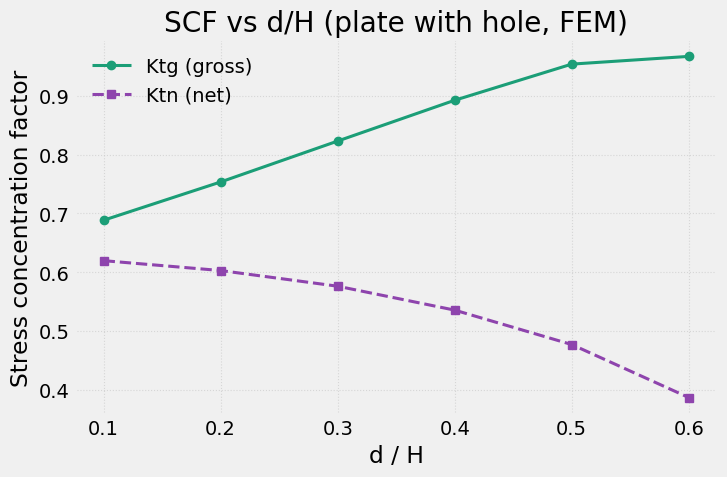

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("fivethirtyeight")

from Physics_model.Kernel_LE.taiwo_linear_elasticity import Driver_LE, Get_Elastic_Moduli
from FemFrameWork.taiwo_shape_functions import ShapeFunctions

# -------------------------------------------------
# Mesh: structured Q4 plate with a circular hole
# -------------------------------------------------
def generate_plate_with_hole_q4(H, L, d, nx=81, ny=41):
    if nx < 2 or ny < 2:
        raise ValueError("nx and ny must be >= 2")

    x = np.linspace(0.0, L, nx)
    y = np.linspace(-H / 2.0, H / 2.0, ny)
    X, Y = np.meshgrid(x, y)
    coord_full = np.column_stack([X.ravel(), Y.ravel()])

    def node_id(i, j):
        return j * nx + i + 1  # 1-based

    a = d / 2.0
    xc, yc = L / 2.0, 0.0

    r_full = np.hypot(coord_full[:, 0] - xc, coord_full[:, 1] - yc)
    in_hole = r_full < a

    elems = []
    for j in range(ny - 1):
        for i in range(nx - 1):
            n1 = node_id(i,     j)
            n2 = node_id(i + 1, j)
            n3 = node_id(i + 1, j + 1)
            n4 = node_id(i,     j + 1)
            if in_hole[n1 - 1] or in_hole[n2 - 1] or in_hole[n3 - 1] or in_hole[n4 - 1]:
                continue
            elems.append([n1, n2, n3, n4])
    if not elems:
        raise RuntimeError("All elements removed; check H, L, d, nx, ny.")

    elems = np.array(elems, dtype=int)
    used = np.unique(elems.ravel())
    remap = np.zeros(used.max() + 1, dtype=int)
    remap[used] = np.arange(1, used.size + 1)
    coord = coord_full[used - 1, :]
    connectivity = remap[elems]

    xC, yC = coord[:, 0], coord[:, 1]
    tolx, toly = 1e-10 * max(1.0, L), 1e-10 * max(1.0, H)
    left_nodes   = np.where(np.abs(xC - 0.0) < tolx)[0]
    right_nodes  = np.where(np.abs(xC - L)   < tolx)[0]
    bottom_nodes = np.where(np.abs(yC + H/2) < toly)[0]
    top_nodes    = np.where(np.abs(yC - H/2) < toly)[0]

    left_nodes   = left_nodes[np.argsort(yC[left_nodes])]   + 1
    right_nodes  = right_nodes[np.argsort(yC[right_nodes])] + 1
    bottom_nodes = bottom_nodes[np.argsort(xC[bottom_nodes])] + 1
    top_nodes    = top_nodes[np.argsort(xC[top_nodes])]       + 1

    elem_centers = coord[connectivity - 1].mean(axis=1)
    r_elem = np.hypot(elem_centers[:, 0] - xc, elem_centers[:, 1] - yc)
    r_hole_fe = r_elem.min()

    r_nodes = np.hypot(xC - xc, yC - yc)
    hmin = min(L / (nx - 1), H / (ny - 1))
    hole_band = np.abs(r_nodes - r_hole_fe) <= 0.8 * hmin
    hole_nodes = np.where(hole_band)[0] + 1

    hole_center = np.array([xc, yc], float)
    hole_radius = r_hole_fe

    return coord, connectivity, left_nodes, right_nodes, hole_nodes, hole_center, hole_radius

# -------------------------------------------------
# Traction → nodal point loads on an edge
# -------------------------------------------------
def build_edge_traction_loads(coord, edge_node_ids, traction, dof_index):
    edge_node_ids = np.asarray(edge_node_ids, dtype=int)
    if edge_node_ids.size < 2:
        raise ValueError("Need at least two nodes on the edge.")
    idx0 = edge_node_ids - 1
    pts = coord[idx0, :]
    dx_span = np.ptp(pts[:, 0])
    dy_span = np.ptp(pts[:, 1])
    if dy_span >= dx_span:
        order = np.argsort(pts[:, 1])
        param = pts[order, 1]
    else:
        order = np.argsort(pts[:, 0])
        param = pts[order, 0]
    sorted_ids = edge_node_ids[order]
    L = float(param[-1] - param[0])
    if L <= 0.0:
        raise RuntimeError("Degenerate edge length.")
    F_total = traction * L
    N = sorted_ids.size
    Pint = F_total / (N - 1)
    nodal = np.zeros(N, float)
    for k in range(N):
        nodal[k] = 0.5 * Pint if k == 0 or k == N - 1 else Pint
    return np.column_stack([sorted_ids, np.full(N, dof_index, float), nodal])

def build_scf_point_loads(coord, left_nodes, right_nodes, sigma):
    left_loads = build_edge_traction_loads(coord, left_nodes, traction=+sigma, dof_index=1)
    right_loads = build_edge_traction_loads(coord, right_nodes, traction=-sigma, dof_index=1)
    return np.vstack([left_loads, right_loads])

# -------------------------------------------------
# Stress recovery: nodal (avg of corner stresses), plane stress
# -------------------------------------------------
def stress_recovery_fulltensor_q4(connectivity, coord, U, medium_set):
    num_nodes = coord.shape[0]
    nele = connectivity.shape[0]
    sxx_acc = np.zeros(num_nodes)
    syy_acc = np.zeros(num_nodes)
    sxy_acc = np.zeros(num_nodes)
    count = np.zeros(num_nodes)
    ref_corners = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1]], float)

    for e in range(nele):
        nodes = connectivity[e, :] - 1
        x_e = coord[nodes, :]
        u_e = U[nodes, :].reshape(-1)  # [u1,v1,u2,v2,...]

        for loc, (xi, eta) in enumerate(ref_corners):
            N, dN_dxi = ShapeFunctions("Q4", np.array([xi, eta]))
            J = x_e.T @ dN_dxi
            invJ = np.linalg.inv(J)
            dN_dx = dN_dxi @ invJ

            B = np.zeros((3, 8))
            for i in range(4):
                B[0, 2*i]     = dN_dx[i, 0]
                B[1, 2*i + 1] = dN_dx[i, 1]
                B[2, 2*i]     = dN_dx[i, 1]
                B[2, 2*i + 1] = dN_dx[i, 0]

            strain = B @ u_e
            eps_xx, eps_yy, gamma_xy = strain
            lam, mu = Get_Elastic_Moduli(medium_set)
            # plane stress
            sigma_xx = (lam + 2*mu) * eps_xx + lam * eps_yy
            sigma_yy = lam * eps_xx + (lam + 2*mu) * eps_yy
            sigma_xy = mu * gamma_xy

            gid = nodes[loc]
            sxx_acc[gid] += sigma_xx
            syy_acc[gid] += sigma_yy
            sxy_acc[gid] += sigma_xy
            count[gid] += 1

    count[count == 0] = 1.0
    sigma_nodes = np.zeros((num_nodes, 5))
    sigma_nodes[:, 0:2] = coord
    sigma_nodes[:, 2] = sxx_acc / count
    sigma_nodes[:, 3] = syy_acc / count
    sigma_nodes[:, 4] = sxy_acc / count
    return sigma_nodes

# -------------------------------------------------
# Hoop stress on the hole and sigma_max
# -------------------------------------------------
def compute_arc_angle(pt, center):
    dx = pt[0] - center[0]
    dy = pt[1] - center[1]
    return np.arctan2(dy, dx)

def compute_hoop_stress(sxx, syy, sxy, theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return sxx * s * s + syy * c * c - 2.0 * sxy * s * c

def compute_sigmaA(connectivity, coord, U, medium_set, hole_nodes, hole_center):
    sigma_nodes = stress_recovery_fulltensor_q4(connectivity, coord, U, medium_set)
    hole_nodes = np.asarray(hole_nodes, dtype=int)
    sigma_theta = []
    theta_list = []
    coord_list = []
    for nid in hole_nodes:
        i = nid - 1
        x, y = sigma_nodes[i, 0], sigma_nodes[i, 1]
        sxx, syy, sxy = sigma_nodes[i, 2], sigma_nodes[i, 3], sigma_nodes[i, 4]
        theta = compute_arc_angle([x, y], hole_center)
        sigma_theta.append(compute_hoop_stress(sxx, syy, sxy, theta))
        theta_list.append(theta)
        coord_list.append([x, y])
    sigma_theta = np.array(sigma_theta)
    idx_max = int(np.argmax(sigma_theta))
    return {
        "sigma_theta": sigma_theta,
        "theta": np.array(theta_list),
        "coords": np.array(coord_list),
        "sigma_max": float(sigma_theta[idx_max]),
        "node_max": int(hole_nodes[idx_max]),
        "coord_max": np.array(coord_list)[idx_max],
    }

# -------------------------------------------------
# One SCF run at a given d/H
# -------------------------------------------------
def run_scf_ratio(ratio, d=0.2, sigma_inf=1.0, nx=81, ny=41):
    H = d / ratio if ratio > 0 else 1e6
    Hmax = d / min_ratio if ratio > 0 else H  # placeholder; set outside
    L = 5.0 * Hmax

    coord, connectivity, left_nodes, right_nodes, hole_nodes, hole_center, _ = \
        generate_plate_with_hole_q4(H=H, L=L, d=d, nx=nx, ny=ny)

    num_nodes = coord.shape[0]
    nele = connectivity.shape[0]

    E = 200e6
    nu = 0.0
    lam = E * nu / ((1 + nu) * (1 - 2 * nu))
    mu = 0.5 * E / (1 + nu)
    medium_set = {"type": "Lame_params", "lambda": lam, "mu": mu}

    load_type = {"case": "2D_gravity", "rhob": 0.0}

    # minimal constraints away from the hole: pin two left-edge nodes
    ref_node = int(left_nodes[0])
    aux_node = int(left_nodes[len(left_nodes)//2])
    constraints = np.array([
        [ref_node, 1, 0.0],
        [ref_node, 2, 0.0],
        [aux_node, 2, 0.0],
    ], dtype=float)
    ncons = constraints.shape[0]

    ptload = build_scf_point_loads(coord, left_nodes, right_nodes, sigma_inf)

    U = Driver_LE(
        connectivity,
        constraints,
        coord,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q4",
        load_type=load_type,
        NCons=ncons,
        Nele=nele,
        NGPTS=2,
        point_load=ptload,
    ).reshape(num_nodes, 2)

    result = compute_sigmaA(connectivity, coord, U, medium_set, hole_nodes, hole_center)
    sigma_max = result["sigma_max"]
    Ktg = sigma_max / sigma_inf
    Ktn = Ktg * (1.0 - ratio)

    return {
        "ratio": ratio,
        "Ktg": Ktg,
        "Ktn": Ktn,
        "sigma_max": sigma_max,
        "sigma_inf": sigma_inf,
    }

# -------------------------------------------------
# Sweep d/H and plot
# -------------------------------------------------
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
min_ratio = min(ratios)  # for L = 5*H_max in run_scf_ratio

results = [run_scf_ratio(r) for r in ratios]
Ktg_list = [r["Ktg"] for r in results]
Ktn_list = [r["Ktn"] for r in results]

plt.figure(figsize=(7.5, 5.0))
plt.plot(ratios, Ktg_list, "o-", linewidth=2.2, markersize=6, color="#1B9E77", label="Ktg (gross)")
plt.plot(ratios, Ktn_list, "s--", linewidth=2.2, markersize=6, color="#8E44AD", label="Ktn (net)")
plt.xlabel("d / H")
plt.ylabel("Stress concentration factor")
plt.title("SCF vs d/H (plate with hole, FEM)")
plt.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("SCF_vs_ratio_fem.png", dpi=300)
plt.show()


       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...             

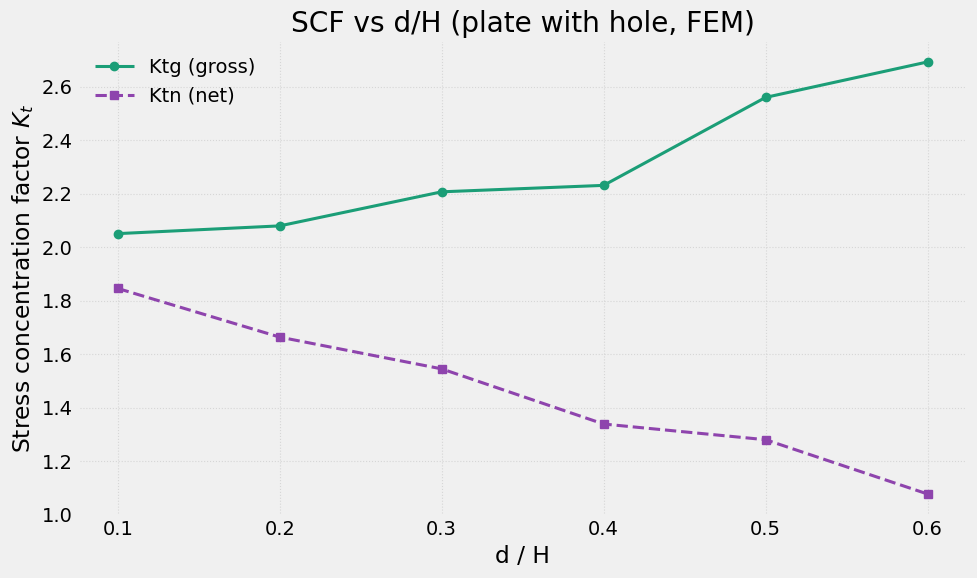

In [54]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

from Physics_model.Kernel_LE.taiwo_linear_elasticity import Driver_LE
from FemFrameWork.taiwo_shape_functions import ShapeFunctions

# -------------------------------------------------
# Plate with circular hole (structured Q4, drop hole cells)
# -------------------------------------------------
def generate_plate_with_hole_q4(H, L, d, nx=100, ny=50):
    x = np.linspace(0.0, L, nx)
    y = np.linspace(-H / 2.0, H / 2.0, ny)
    X, Y = np.meshgrid(x, y)
    coord_full = np.column_stack([X.ravel(), Y.ravel()])

    def node_id(i, j):
        return j * nx + i + 1  # 1-based

    a = d / 2.0
    xc, yc = L / 2.0, 0.0
    r_full = np.hypot(coord_full[:, 0] - xc, coord_full[:, 1] - yc)
    in_hole = r_full < a

    elems = []
    for j in range(ny - 1):
        for i in range(nx - 1):
            n1 = node_id(i,     j)
            n2 = node_id(i + 1, j)
            n3 = node_id(i + 1, j + 1)
            n4 = node_id(i,     j + 1)
            if in_hole[n1 - 1] or in_hole[n2 - 1] or in_hole[n3 - 1] or in_hole[n4 - 1]:
                continue
            elems.append([n1, n2, n3, n4])
    if not elems:
        raise RuntimeError("All elements removed; check geometry/mesh.")

    elems = np.array(elems, dtype=int)
    used = np.unique(elems.ravel())
    remap = np.zeros(used.max() + 1, dtype=int)
    remap[used] = np.arange(1, used.size + 1)

    coord = coord_full[used - 1, :]
    connectivity = remap[elems]

    xC, yC = coord[:, 0], coord[:, 1]
    tolx, toly = 1e-10 * max(1.0, L), 1e-10 * max(1.0, H)

    left_nodes  = np.where(np.abs(xC - 0.0) < tolx)[0]
    right_nodes = np.where(np.abs(xC - L)   < tolx)[0]
    left_nodes  = left_nodes[np.argsort(yC[left_nodes])]   + 1
    right_nodes = right_nodes[np.argsort(yC[right_nodes])] + 1

    elem_centers = coord[connectivity - 1].mean(axis=1)
    r_elem = np.hypot(elem_centers[:, 0] - xc, elem_centers[:, 1] - yc)
    r_hole_fe = r_elem.min()

    r_nodes = np.hypot(xC - xc, yC - yc)
    hmin = min(L / (nx - 1), H / (ny - 1))
    hole_mask = np.abs(r_nodes - r_hole_fe) <= 0.8 * hmin
    hole_nodes = np.where(hole_mask)[0] + 1

    hole_center = np.array([xc, yc], float)
    return coord, connectivity, left_nodes, right_nodes, hole_nodes, hole_center

# -------------------------------------------------
# Edge traction -> nodal loads (trapezoidal)
# -------------------------------------------------
def build_edge_traction_loads(coord, edge_node_ids, traction, dof_index):
    edge_node_ids = np.asarray(edge_node_ids, dtype=int)
    if edge_node_ids.size < 2:
        raise ValueError("Need at least two nodes on the edge.")
    idx0 = edge_node_ids - 1
    pts = coord[idx0, :]
    dx_span = np.ptp(pts[:, 0]); dy_span = np.ptp(pts[:, 1])
    if dy_span >= dx_span:
        order = np.argsort(pts[:, 1]); param = pts[order, 1]
    else:
        order = np.argsort(pts[:, 0]); param = pts[order, 0]
    sorted_ids = edge_node_ids[order]
    Ledge = float(param[-1] - param[0])
    Pint = traction * Ledge / (sorted_ids.size - 1)
    nodal = np.zeros(sorted_ids.size, float)
    for k in range(sorted_ids.size):
        nodal[k] = 0.5 * Pint if k in (0, sorted_ids.size - 1) else Pint
    return np.column_stack([sorted_ids, np.full(sorted_ids.size, dof_index, float), nodal])

def build_scf_point_loads(coord, left_nodes, right_nodes, sigma):
    # left gets -sigma, right gets +sigma
    left_loads = build_edge_traction_loads(coord, left_nodes, traction=-sigma, dof_index=1)
    right_loads = build_edge_traction_loads(coord, right_nodes, traction=+sigma, dof_index=1)
    return np.vstack([left_loads, right_loads])

# -------------------------------------------------
# Stress recovery (plane strain-style, corner average)
# -------------------------------------------------
def stress_recovery_fulltensor_q4(connectivity, coord, U, medium_set):
    num_nodes = coord.shape[0]
    nele = connectivity.shape[0]
    sxx_acc = np.zeros(num_nodes)
    syy_acc = np.zeros(num_nodes)
    sxy_acc = np.zeros(num_nodes)
    count = np.zeros(num_nodes)
    ref_corners = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1]], float)

    lam = medium_set["lambda"]; mu = medium_set["mu"]

    for e in range(nele):
        nodes = connectivity[e, :] - 1
        x_e = coord[nodes, :]
        u_e = U[nodes, :].reshape(-1)
        for loc, (xi, eta) in enumerate(ref_corners):
            N, dN_dxi = ShapeFunctions("Q4", np.array([xi, eta]))
            J = x_e.T @ dN_dxi
            invJ = np.linalg.inv(J)
            dN_dx = dN_dxi @ invJ

            B = np.zeros((3, 8))
            for i in range(4):
                B[0, 2*i]     = dN_dx[i, 0]
                B[1, 2*i + 1] = dN_dx[i, 1]
                B[2, 2*i]     = dN_dx[i, 1]
                B[2, 2*i + 1] = dN_dx[i, 0]

            strain = B @ u_e
            eps_xx, eps_yy, eps_xy = strain
            sigma_xx = (lam + 2.0 * mu) * eps_xx + lam * eps_yy
            sigma_yy = lam * eps_xx + (lam + 2.0 * mu) * eps_yy
            sigma_xy = 2.0 * mu * eps_xy

            gid = nodes[loc]
            sxx_acc[gid] += sigma_xx
            syy_acc[gid] += sigma_yy
            sxy_acc[gid] += sigma_xy
            count[gid] += 1

    count[count == 0] = 1.0
    out = np.zeros((num_nodes, 5))
    out[:, 0:2] = coord
    out[:, 2] = sxx_acc / count
    out[:, 3] = syy_acc / count
    out[:, 4] = sxy_acc / count
    return out

# -------------------------------------------------
# Hoop stress and sigma_max on the hole
# -------------------------------------------------
def compute_arc_angle(pt, center):
    dx = pt[0] - center[0]; dy = pt[1] - center[1]
    return np.arctan2(dy, dx)

def compute_hoop_stress(sxx, syy, sxy, theta):
    c = np.cos(theta); s = np.sin(theta)
    return sxx * s * s + syy * c * c - 2.0 * sxy * s * c

def compute_sigmaA(connectivity, coord, U, medium_set, hole_nodes, hole_center):
    sigma_nodes = stress_recovery_fulltensor_q4(connectivity, coord, U, medium_set)
    hole_nodes = np.asarray(hole_nodes, dtype=int)
    sigma_theta = []
    for nid in hole_nodes:
        i = nid - 1
        x, y = sigma_nodes[i, 0], sigma_nodes[i, 1]
        sxx, syy, sxy = sigma_nodes[i, 2], sigma_nodes[i, 3], sigma_nodes[i, 4]
        theta = compute_arc_angle([x, y], hole_center)
        sigma_theta.append(compute_hoop_stress(sxx, syy, sxy, theta))
    sigma_theta = np.array(sigma_theta)
    return float(sigma_theta.max())

# -------------------------------------------------
# One SCF run at a given d/H
# -------------------------------------------------
def run_scf_ratio(ratio, d=0.2, sigma_inf=1e4 / 15e-3, nx=81, ny=41):
    H = d / ratio
    L = 10.0

    coord, connectivity, left_nodes, right_nodes, hole_nodes, hole_center = \
        generate_plate_with_hole_q4(H=H, L=L, d=d, nx=nx, ny=ny)

    num_nodes = coord.shape[0]
    nele = connectivity.shape[0]

    E = 200e6
    nu = 0.0
    lam = E * nu / ((1 + nu) * (1 - 2 * nu))
    mu = 0.5 * E / (1 + nu)

    # FIX: add type so Get_Elastic_Moduli recognizes it
    medium_set = {
        "type": "Lame_params",
        "lambda": lam,
        "mu": mu,
    }

    load_type = {"case": "2D_gravity", "rhob": 0.0}

    # Hole-based constraints: fix one hole node (ux,uy) and one opposite (uy)
    hole_coords = coord[hole_nodes - 1, :]
    xs = hole_coords[:, 0]
    left_hole = int(hole_nodes[np.argmin(xs)])
    right_hole = int(hole_nodes[np.argmax(xs)])
    constraints = np.array([
        [left_hole, 1, 0.0],
        [left_hole, 2, 0.0],
        [right_hole, 2, 0.0],
    ], dtype=float)
    ncons = constraints.shape[0]

    ptload = build_scf_point_loads(coord, left_nodes, right_nodes, sigma_inf)

    U = Driver_LE(
        connectivity,
        constraints,
        coord,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q4",
        load_type=load_type,
        NCons=ncons,
        Nele=nele,
        NGPTS=2,
        point_load=ptload,
    ).reshape(num_nodes, 2)

    sigma_max = compute_sigmaA(connectivity, coord, U, medium_set, hole_nodes, hole_center)
    Ktg = sigma_max / sigma_inf
    Ktn = Ktg * (1.0 - ratio)
    return {"ratio": ratio, "Ktg": Ktg, "Ktn": Ktn, "sigma_max": sigma_max}

# -------------------------------------------------
# Sweep and plot
# -------------------------------------------------
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
results = [run_scf_ratio(r) for r in ratios]

Ktg_list = [r["Ktg"] for r in results]
Ktn_list = [r["Ktn"] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(ratios, Ktg_list, "o-", linewidth=2.2, markersize=6, color="#1B9E77", label="Ktg (gross)")
plt.plot(ratios, Ktn_list, "s--", linewidth=2.2, markersize=6, color="#8E44AD", label="Ktn (net)")
plt.xlabel("d / H")
plt.ylabel(r"Stress concentration factor $K_t$")
plt.title("SCF vs d/H (plate with hole, FEM)")
plt.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("SCF_vs_ratio_style.pdf", dpi=300)
plt.show()


       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...                       
               Simulation Completed                     
       Quasi-static Linear Elasticity Simulation Status Report               
       Step 1: Creating Global ID Matrix...             
       Step 2: Creating Constraints Vector...           
       Step 3: Calculating Global Matrices...           
       Step 3.5: Applying Nodal Point Loads...          
       Point loads applied successfully.                
       Step 4: Solving Linear Equations...              
       Step 5: Post-Processing...             

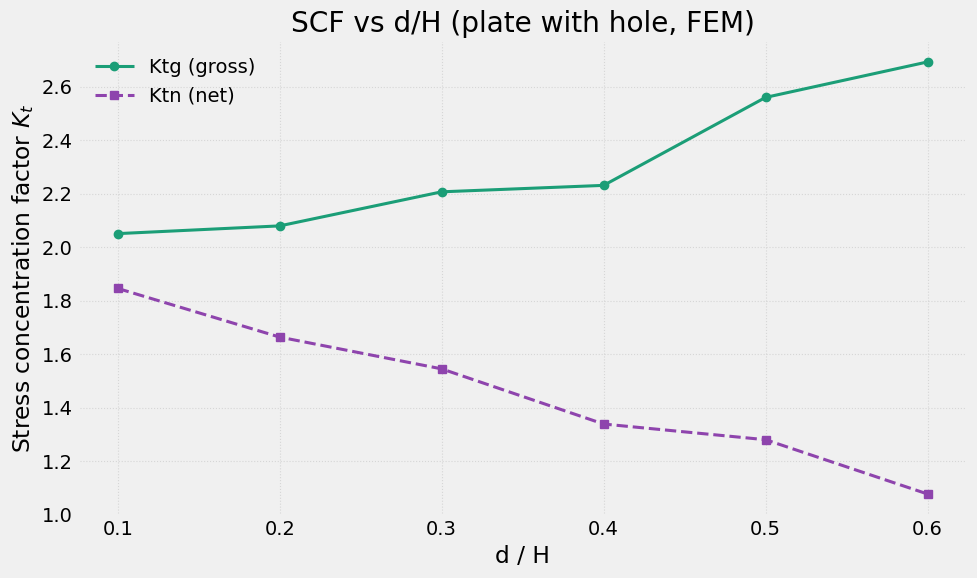

In [57]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

from Physics_model.Kernel_LE.taiwo_linear_elasticity import Driver_LE
from FemFrameWork.taiwo_shape_functions import ShapeFunctions

# -------------------------------------------------
# Mesh: structured Q4 plate with a circular hole
# -------------------------------------------------
def generate_plate_with_hole_q4(H, L, d, nx=81, ny=41):
    x = np.linspace(0.0, L, nx)
    y = np.linspace(-H / 2.0, H / 2.0, ny)
    X, Y = np.meshgrid(x, y)
    coord_full = np.column_stack([X.ravel(), Y.ravel()])

    def node_id(i, j):
        return j * nx + i + 1  # 1-based

    a = d / 2.0
    xc, yc = L / 2.0, 0.0
    r_full = np.hypot(coord_full[:, 0] - xc, coord_full[:, 1] - yc)
    in_hole = r_full < a

    elems = []
    for j in range(ny - 1):
        for i in range(nx - 1):
            n1 = node_id(i,     j)
            n2 = node_id(i + 1, j)
            n3 = node_id(i + 1, j + 1)
            n4 = node_id(i,     j + 1)
            if in_hole[n1 - 1] or in_hole[n2 - 1] or in_hole[n3 - 1] or in_hole[n4 - 1]:
                continue
            elems.append([n1, n2, n3, n4])

    if not elems:
        raise RuntimeError("All elements removed; check geometry/mesh.")

    elems = np.array(elems, dtype=int)
    used = np.unique(elems.ravel())
    remap = np.zeros(used.max() + 1, dtype=int)
    remap[used] = np.arange(1, used.size + 1)
    coord = coord_full[used - 1, :]
    connectivity = remap[elems]

    xC, yC = coord[:, 0], coord[:, 1]
    tolx, toly = 1e-10 * max(1.0, L), 1e-10 * max(1.0, H)
    left_nodes  = np.where(np.abs(xC - 0.0) < tolx)[0]
    right_nodes = np.where(np.abs(xC - L)   < tolx)[0]
    left_nodes  = left_nodes[np.argsort(yC[left_nodes])]   + 1
    right_nodes = right_nodes[np.argsort(yC[right_nodes])] + 1

    elem_centers = coord[connectivity - 1].mean(axis=1)
    r_elem = np.hypot(elem_centers[:, 0] - xc, elem_centers[:, 1] - yc)
    r_hole_fe = r_elem.min()

    r_nodes = np.hypot(xC - xc, yC - yc)
    hmin = min(L / (nx - 1), H / (ny - 1))
    hole_mask = np.abs(r_nodes - r_hole_fe) <= 0.8 * hmin
    hole_nodes = np.where(hole_mask)[0] + 1

    hole_center = np.array([xc, yc], float)
    return coord, connectivity, left_nodes, right_nodes, hole_nodes, hole_center

# -------------------------------------------------
# Edge traction -> nodal loads (trapezoidal)
# -------------------------------------------------
def build_edge_traction_loads(coord, edge_node_ids, traction, dof_index):
    edge_node_ids = np.asarray(edge_node_ids, dtype=int)
    if edge_node_ids.size < 2:
        raise ValueError("Need at least two nodes on the edge.")
    idx0 = edge_node_ids - 1
    pts = coord[idx0, :]
    dx_span = np.ptp(pts[:, 0]); dy_span = np.ptp(pts[:, 1])
    if dy_span >= dx_span:
        order = np.argsort(pts[:, 1]); param = pts[order, 1]
    else:
        order = np.argsort(pts[:, 0]); param = pts[order, 0]
    sorted_ids = edge_node_ids[order]
    Ledge = float(param[-1] - param[0])
    Pint = traction * Ledge / (sorted_ids.size - 1)
    nodal = np.zeros(sorted_ids.size, float)
    for k in range(sorted_ids.size):
        nodal[k] = 0.5 * Pint if k in (0, sorted_ids.size - 1) else Pint
    return np.column_stack([sorted_ids, np.full(sorted_ids.size, dof_index, float), nodal])

def build_scf_point_loads(coord, left_nodes, right_nodes, sigma):
    # Left edge: -sigma; Right edge: +sigma
    left_loads = build_edge_traction_loads(coord, left_nodes, traction=-sigma, dof_index=1)
    right_loads = build_edge_traction_loads(coord, right_nodes, traction=+sigma, dof_index=1)
    return np.vstack([left_loads, right_loads])

# -------------------------------------------------
# Stress recovery with 2D-aware grad_u
# -------------------------------------------------
def stress_recovery_fulltensor_q4_grad(connectivity, coord, U, medium_set):
    num_nodes = coord.shape[0]
    nele = connectivity.shape[0]
    sxx_acc = np.zeros(num_nodes)
    syy_acc = np.zeros(num_nodes)
    sxy_acc = np.zeros(num_nodes)
    count = np.zeros(num_nodes)

    lam = medium_set["lambda"]; mu = medium_set["mu"]
    ref_corners = np.array([[-1, -1],
                            [ 1, -1],
                            [ 1,  1],
                            [-1,  1]], float)

    for e in range(nele):
        nodes = connectivity[e, :] - 1
        xCap = coord[nodes, :]          # (4,2)
        UCap = U[nodes, :]              # (4,2)

        for loc, (xi, eta) in enumerate(ref_corners):
            z = np.array([xi, eta], float)
            N, DN = ShapeFunctions("Q4", z)  # DN: (4,2) wrt (xi,eta)

            J = xCap.T @ DN
            detJ = np.linalg.det(J)
            if detJ <= 0.0:
                raise ValueError(f"det(J)<=0 in element {e+1}, detJ={detJ:.3e}")
            invJ = np.linalg.inv(J)
            dNdx = DN @ invJ  # (4,2)

            # grad_u (2x2) = UCap^T (2x4) * dNdx (4x2)
            grad_u = UCap.T @ dNdx

            # Small strain tensor
            eps = 0.5 * (grad_u + grad_u.T)
            eps_xx = eps[0, 0]
            eps_yy = eps[1, 1]
            eps_xy = eps[0, 1]  # same as eps[1,0]

            # Plane strain form (nu=0 => plane stress/strain coincide)
            sigma_xx = (lam + 2.0 * mu) * eps_xx + lam * eps_yy
            sigma_yy = lam * eps_xx + (lam + 2.0 * mu) * eps_yy
            sigma_xy = 2.0 * mu * eps_xy

            gid = nodes[loc]
            sxx_acc[gid] += sigma_xx
            syy_acc[gid] += sigma_yy
            sxy_acc[gid] += sigma_xy
            count[gid] += 1

    count[count == 0] = 1.0
    sigma_nodes = np.zeros((num_nodes, 5))
    sigma_nodes[:, 0:2] = coord
    sigma_nodes[:, 2] = sxx_acc / count
    sigma_nodes[:, 3] = syy_acc / count
    sigma_nodes[:, 4] = sxy_acc / count
    return sigma_nodes

# -------------------------------------------------
# Hoop stress and sigma_max on the hole
# -------------------------------------------------
def compute_arc_angle(pt, center):
    dx = pt[0] - center[0]; dy = pt[1] - center[1]
    return np.arctan2(dy, dx)

def compute_hoop_stress(sxx, syy, sxy, theta):
    c = np.cos(theta); s = np.sin(theta)
    return sxx * s * s + syy * c * c - 2.0 * sxy * s * c

def compute_sigmaA(connectivity, coord, U, medium_set, hole_nodes, hole_center):
    sigma_nodes = stress_recovery_fulltensor_q4_grad(connectivity, coord, U, medium_set)
    hole_nodes = np.asarray(hole_nodes, dtype=int)
    sigma_theta = []
    for nid in hole_nodes:
        i = nid - 1
        x, y = sigma_nodes[i, 0], sigma_nodes[i, 1]
        sxx, syy, sxy = sigma_nodes[i, 2], sigma_nodes[i, 3], sigma_nodes[i, 4]
        theta = compute_arc_angle([x, y], hole_center)
        sigma_theta.append(compute_hoop_stress(sxx, syy, sxy, theta))
    sigma_theta = np.array(sigma_theta)
    return float(sigma_theta.max())

# -------------------------------------------------
# One SCF run at a given d/H
# -------------------------------------------------
def run_scf_ratio(ratio, d=0.2, sigma_inf=1e4 / 15e-3, nx=81, ny=41):
    H = d / ratio
    L = 10.0

    coord, connectivity, left_nodes, right_nodes, hole_nodes, hole_center = \
        generate_plate_with_hole_q4(H=H, L=L, d=d, nx=nx, ny=ny)

    num_nodes = coord.shape[0]
    nele = connectivity.shape[0]

    E = 200e6
    nu = 0.0
    lam = E * nu / ((1 + nu) * (1 - 2 * nu))
    mu = 0.5 * E / (1 + nu)
    medium_set = {"type": "Lame_params", "lambda": lam, "mu": mu}

    load_type = {"case": "2D_gravity", "rhob": 0.0}

    # Hole-based constraints: fix left hole node (ux,uy) and right hole node (uy)
    hole_coords = coord[hole_nodes - 1, :]
    xs = hole_coords[:, 0]
    left_hole = int(hole_nodes[np.argmin(xs)])
    right_hole = int(hole_nodes[np.argmax(xs)])
    constraints = np.array([
        [left_hole, 1, 0.0],
        [left_hole, 2, 0.0],
        [right_hole, 2, 0.0],
    ], dtype=float)
    ncons = constraints.shape[0]

    ptload = build_scf_point_loads(coord, left_nodes, right_nodes, sigma_inf)

    U = Driver_LE(
        connectivity,
        constraints,
        coord,
        medium_set,
        dim=2,
        dofs_per_node=2,
        EleType="Q4",
        load_type=load_type,
        NCons=ncons,
        Nele=nele,
        NGPTS=2,
        point_load=ptload,
    ).reshape(num_nodes, 2)

    sigma_max = compute_sigmaA(connectivity, coord, U, medium_set, hole_nodes, hole_center)
    Ktg = sigma_max / sigma_inf
    Ktn = Ktg * (1.0 - ratio)
    return {"ratio": ratio, "Ktg": Ktg, "Ktn": Ktn, "sigma_max": sigma_max}

# -------------------------------------------------
# Sweep and plot
# -------------------------------------------------
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
results = [run_scf_ratio(r) for r in ratios]

Ktg_list = [r["Ktg"] for r in results]
Ktn_list = [r["Ktn"] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(ratios, Ktg_list, "o-", linewidth=2.2, markersize=6, color="#1B9E77", label="Ktg (gross)")
plt.plot(ratios, Ktn_list, "s--", linewidth=2.2, markersize=6, color="#8E44AD", label="Ktn (net)")
plt.xlabel("d / H")
plt.ylabel(r"Stress concentration factor $K_t$")
plt.title("SCF vs d/H (plate with hole, FEM)")
plt.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("SCF_vs_ratio_style.pdf", dpi=300)
plt.show()
